In [1]:
import numpy as np
import pandas as pd

def Ackley(x1, x2):
    term1 = -20 * np.exp(-0.2 * np.sqrt(0.5 * (x1**2 + x2**2)))
    term2 = -np.exp(0.5 * (np.cos(2 * np.pi * x1) + np.cos(2 * np.pi * x2)))
    return term1 + term2 + np.e + 20

def GetGrid(grid):
    x1 = np.linspace(-2, 2, grid)
    x2 = np.linspace(-2, 2, grid)
    x1, x2 = np.meshgrid(x1, x2)
    z = Ackley(x1, x2)
    return x1, x2, z

def create_dataframe(grid):
   x1, x2, z = GetGrid(grid)
   data = {'x1': x1.flatten(), 'x2': x2.flatten(), 'f(x1,x2)': z.flatten()}
   df = pd.DataFrame(data)
   return df


df_1000 = create_dataframe(32)
df_test = create_dataframe(grid=4)
df_training = create_dataframe(grid=5)

df_virtual = pd.read_excel("../VirtualSamples.xlsx", sheet_name="HoleEffect")

/tmp/ipykernel_251105/3623673326.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


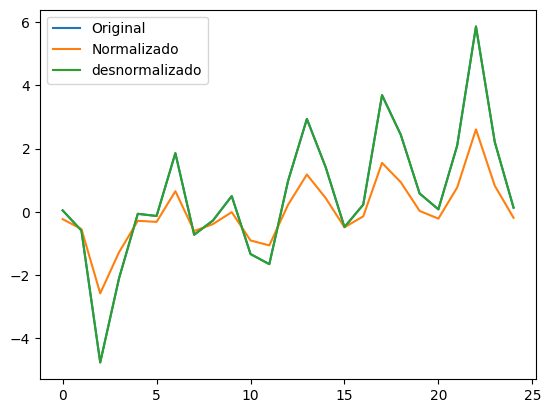

In [2]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def show_norm(df, label="data", plot=False):
    df_norm = pd.DataFrame(scaler.transform(df), columns=df.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df_norm), columns=df_norm.columns)

    if (plot):
        df.plot(title=f"{label}: Original data")
        df_norm.plot(title=f"{label}: Normalized data")
        df_denorm.plot(title=f"{label}: Denormalized data")
    return (df_norm)


def test_out_scaler(df):
    out = df["f(x1,x2)"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

scaler.fit(df_training)
test_out_scaler(df_training)

df_training_norm = show_norm(df_training, "Training")
df_1000_norm = show_norm(df_1000)
df_test_norm = show_norm(df_test)
df_virtual_norm = show_norm(pd.concat([df_training, df_virtual]))

In [3]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

Cloning into 'tf-levenberg-marquardt'...


remote: Enumerating objects: 53, done.
remote: Counting objects:   1% (1/53)
remote: Counting objects:   3% (2/53)
remote: Counting objects:   5% (3/53)
remote: Counting objects:   7% (4/53)
remote: Counting objects:   9% (5/53)
remote: Counting objects:  11% (6/53)
remote: Counting objects:  13% (7/53)
remote: Counting objects:  15% (8/53)
remote: Counting objects:  16% (9/53)
remote: Counting objects:  18% (10/53)
remote: Counting objects:  20% (11/53)
remote: Counting objects:  22% (12/53)
remote: Counting objects:  24% (13/53)
remote: Counting objects:  26% (14/53)
remote: Counting objects:  28% (15/53)
remote: Counting objects:  30% (16/53)
remote: Counting objects:  32% (17/53)
remote: Counting objects:  33% (18/53)
remote: Counting objects:  35% (19/53)
remote: Counting objects:  37% (20/53)
remote: Counting objects:  39% (21/53)
remote: Counting objects:  41% (22/53)
remote: Counting objects:  43% (23/53)
remote: Counting objects:  45% (24/53)
remote: Counting objects:  47% (25

In [4]:
def split_df(df):
    _input = np.vstack([df['x1'], df['x2']]).T
    _output = np.array(df['f(x1,x2)'])
    return (_input, _output)

In [5]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def compute_k(self):
        total_parameters = 0
        for layer in self.model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:  
                for w in weights:
                    total_parameters += np.prod(w.shape)
        return total_parameters
        
    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer

        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-09-09 19:18:39.534527: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-09 19:18:39.593920: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-09 19:18:39.593963: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-09 19:18:39.595169: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-09 19:18:39.607914: I tensorflow/core/platform/cpu_feature_guar

2024-09-09 19:18:44.096876: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error 

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
        self.k = 0

    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)
      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, tester):
      input_train, input_val, output_train, output_val = train_test_split(tester.input, tester.output, test_size=0.2, shuffle = True)

      self.dataset, self.input, self.output = self.create_dataset(tester.input, tester.output)
      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(tester.input_test, tester.output_test)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.sup_dataset, self.sup_input, self.sup_output = self.create_dataset(tester.input_1000, tester.output_1000)

      self._train = (input_train, output_train)
      self._val = (input_val, output_val)
      self._test = (tester.input_test, tester.output_test)
      self._data = (tester.input, tester.output)
      self._sup = (tester.input_1000, tester.output_1000)


    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)
      
      self.lm_model.save_weights('./initial-.weights.h5')
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)
    
    def get_new_metrics(self, orig, pred, r2, mse):
      n = len(orig) # N: quantidade de saidas
      k = self.k
      waste = (orig.flatten() - pred.flatten())

      mape = mean_absolute_percentage_error(orig, pred)  
      r2_adj = 1 - (((n - 1)/(n - k - 1)) * (1 - r2))
      rsd = np.sqrt(np.sum(waste ** 2) / (n - 2))
      rmse = root_mean_squared_error(orig, pred)          
      aic = (-2 * np.log(mse)) + (2 * k)
      bic = (-2 * np.log(mse)) + (k * np.log(n))
      return (mape, r2_adj, rsd, rmse, aic, bic)
      

    def get_metrics(self):
          # Calculando a saida com os dados normalizados
          pred = self.lm_model.predict(self.input).flatten()
          test_pred = self.lm_model.predict(self.test_input).flatten()
          val_pred = self.lm_model.predict(self.val_input).flatten()
          sup_pred = self.lm_model.predict(self.sup_input).flatten()

          # Calculando as metricas com a saida desnormalizada
          pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
          test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
          val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
          sup_pred_denorm = out_scaler.inverse_transform(sup_pred.reshape(-1, 1))

          out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
          test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
          val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
          sup_denorm = out_scaler.inverse_transform(self._sup[1].reshape(-1, 1))

          r2 = r2_score(out_denorm, pred_denorm)
          r2_test = r2_score(test_denorm, test_pred_denorm)
          r2_val = r2_score(val_denorm, val_pred_denorm)
          r2_sup = r2_score(sup_denorm,  sup_pred_denorm)

          mse = mean_squared_error(out_denorm, pred_denorm)
          mse_test = mean_squared_error(test_denorm, test_pred_denorm)
          mse_val = mean_squared_error(val_denorm, val_pred_denorm)
          mse_sup = mean_squared_error(sup_denorm,  sup_pred_denorm)
          
          mape, r2_adj, rsd, rmse, aic, bic = self.get_new_metrics(out_denorm, pred_denorm, r2, mse)
          metrics = {
                          'r2': r2,
                          'r2_sup': r2_sup,
                          'r2_test': r2_test,
                          'r2_val': r2_val,
                          'mse': mse,
                          'mse_sup': mse_sup,
                          'mse_test': mse_test,
                          'mse_val': mse_val,
                          'mape': mape,
                          'rmse': rmse,
                          'r2_adj': r2_adj,
                          'rsd': rsd,
                          'aic': aic,
                          'bic': bic
                          }

          return metrics

In [7]:
import pickle
from itertools import product
import shutil

class Tester:
  def __init__(self, _df, _df_1000, _df_test,  run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = split_df(_df)
    self.input_1000, self.output_1000 = split_df(_df_1000)
    self.input_test, self.output_test = split_df(_df_test)
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=2,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)
    trainer.k = shuffler.compute_k()

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path)
    shutil.move("./initial-.weights.h5",
                f"../models/initial-weights/{fileName}.keras")

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._val, trainer._test), f)
      
  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] <= boundarie): # should be >= to acsending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    return(save)

  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinacao{count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults('mse_sup', header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

# Treinando apenas com dados originais


In [8]:
tester = Tester(
                _df=df_virtual_norm,
                _df_1000=df_1000_norm,
                _df_test = df_test_norm,
                run_times=10, dataset_run_times=50)
tester.Loop(sort_by='mse',
            boundarie = 0.5,
            hidden_sizes = [[12, 2]],
            regularizers=[0.02],
            learning_rate=[0.01])

Testando combinacao1: Hidden Size=[12, 2], regularizer=0.02, learning_rate=0.01


+++++++++++ [1_0] | 1 ++++++++++++++++++


Stopped at epoch:  9



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 7ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 55ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 68ms/step



 1/32 [..............................] - ETA: 3s


 5/32 [===>..........................] - ETA: 0s


 8/32 [======>.......................] - ETA: 0s


10/32 [========>.....................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


22/32 [===================>..........] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 13ms/step


+++++++++++ [1_0] | 2 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 3 ++++++++++++++++++


Stopped at epoch:  9

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 165ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_0] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_0] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_0] | 6 ++++++++++++++++++

Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 7 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 6ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_0] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 9 ++++++++++++++++++


Stopped at epoch:  26

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_0] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 1 ++++++++++++++++++


Stopped at epoch:  20

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



 1/32 [..............................] - ETA: 0s


22/32 [===================>..........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 2 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 14ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


22/32 [===================>..........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 3 ++++++++++++++++++


Stopped at epoch:  10

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


23/32 [====================>.........] - ETA: 0s


32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_1] | 4 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 5 ++++++++++++++++++

Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 10ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


22/32 [===================>..........] - ETA: 0s


32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_1] | 6 ++++++++++++++++++


Stopped at epoch:  14

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


22/32 [===================>..........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 47ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_1] | 8 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 30ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_1] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_2] | 1 ++++++++++++++++++


Stopped at epoch:  17

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


20/32 [=================>............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 3 ++++++++++++++++++


Stopped at epoch:  12

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 6ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 6ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 57ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_2] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 30ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 1s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


27/32 [========================>.....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_2] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


21/32 [==================>...........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 35ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_2_3,0.886815,0.657192,0.652437,0.901948,0.471134,2.292358,1.243214,0.323550,0.930500,0.686392,8.243816,0.697202,131.505225,272.840398
model_1_2_2,0.884925,0.655310,0.650571,0.901750,0.479004,2.304946,1.249887,0.324201,0.939410,0.692101,8.364818,0.703001,131.472093,272.807266
model_1_2_4,0.897582,0.655179,0.625909,0.919512,0.426319,2.305819,1.338101,0.265591,0.932012,0.652931,7.554772,0.663214,131.705135,273.040307
model_1_2_1,0.882979,0.653638,0.649464,0.901271,0.487101,2.316125,1.253847,0.325784,0.948188,0.697926,8.489314,0.708918,131.438567,272.773740
model_1_2_0,0.880649,0.652457,0.649715,0.898600,0.496802,2.324023,1.252947,0.334598,0.960813,0.704842,8.638468,0.715942,131.399128,272.734300


DataFrame salvo em ../results/metrics_1_2


+++++++++++ [1_3] | 1 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 2 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 0s


21/32 [==================>...........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


11/32 [=========>....................] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_3] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 5 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_3] | 7 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


21/32 [==================>...........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 30ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 0s


22/32 [===================>..........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_3_9,0.922396,0.672971,0.626954,0.934317,0.323030,2.186848,1.334365,0.257563,0.821214,0.568357,5.966669,0.577308,132.260023,273.595195
model_1_3_7,0.919469,0.672709,0.631873,0.931612,0.335211,2.188594,1.316769,0.268170,0.837472,0.578975,6.153970,0.588093,132.185987,273.521160
model_1_3_8,0.920872,0.672625,0.628323,0.933134,0.329371,2.189155,1.329467,0.262201,0.829254,0.573909,6.064171,0.582947,132.221141,273.556313
model_1_3_6,0.917730,0.667855,0.624693,0.928663,0.342451,2.221052,1.342451,0.279736,0.841091,0.585194,6.265287,0.594410,132.143250,273.478423
model_1_3_5,0.914936,0.666755,0.625812,0.926762,0.354080,2.228410,1.338450,0.287189,0.855640,0.595046,6.444081,0.604418,132.076464,273.411636
model_1_3_4,0.913152,0.665472,0.626114,0.924855,0.361507,2.236992,1.337370,0.294668,0.863634,0.601254,6.558267,0.610723,132.034949,273.370121
model_1_3_2,0.907004,0.659778,0.623791,0.918414,0.387100,2.275063,1.345678,0.319926,0.893280,0.622174,6.951771,0.631972,131.898144,273.233317
model_1_3_3,0.908118,0.658920,0.625039,0.917278,0.382460,2.280803,1.341214,0.324378,0.888686,0.618433,6.880422,0.628173,131.922265,273.257437
model_1_3_0,0.899253,0.656893,0.632730,0.902460,0.419362,2.294360,1.313703,0.382486,0.926573,0.647582,7.447808,0.657780,131.738041,273.073214
model_1_3_1,0.902667,0.656523,0.628787,0.905622,0.405151,2.296829,1.327807,0.370085,0.912863,0.636515,7.229310,0.646539,131.806990,273.142163


DataFrame salvo em ../results/metrics_1_3


+++++++++++ [1_4] | 1 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_4] | 2 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 1s


13/32 [===========>..................] - ETA: 0s


26/32 [=======================>......] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_4] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 4 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 10ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 5 ++++++++++++++++++


Stopped at epoch:  10

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_4] | 6 ++++++++++++++++++


Stopped at epoch:  17

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_4] | 8 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 43ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_4] | 9 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


13/32 [===========>..................] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_4_4,0.941713,0.692051,0.655516,0.934836,0.242622,2.059254,1.232198,0.169118,0.714832,0.492567,4.730387,0.500325,132.832498,274.167670
model_1_4_3,0.936905,0.686124,0.639887,0.929288,0.262633,2.098888,1.288103,0.183516,0.733500,0.512478,5.038059,0.520549,132.673993,274.009166
model_1_4_2,0.928940,0.683505,0.650527,0.923829,0.295790,2.116401,1.250045,0.197684,0.778177,0.543865,5.547846,0.552431,132.436214,273.771387
model_1_4_1,0.928014,0.683351,0.651917,0.922688,0.299642,2.117434,1.245071,0.200647,0.787214,0.547396,5.607086,0.556017,132.410331,273.745503
model_1_4_0,0.925249,0.680351,0.651235,0.918658,0.311153,2.137492,1.247512,0.211106,0.807409,0.557811,5.784060,0.566596,132.334942,273.670115
model_1_4_6,0.951612,0.677081,0.603367,0.937819,0.201415,2.159361,1.418732,0.161376,0.664364,0.448793,4.096812,0.455861,133.204775,274.539948
model_1_4_5,0.951458,0.675483,0.598107,0.940115,0.202059,2.170048,1.437546,0.155419,0.667521,0.449510,4.106710,0.456589,133.198393,274.533565
model_1_4_7,0.953372,0.671100,0.591231,0.937713,0.194092,2.199357,1.462142,0.161653,0.650962,0.440559,3.984223,0.447497,133.278843,274.614015
model_1_4_9,0.957091,0.668511,0.587712,0.934931,0.178609,2.216672,1.474729,0.168872,0.627720,0.422621,3.746157,0.429277,133.445116,274.780289
model_1_4_8,0.956689,0.667323,0.584078,0.933514,0.180283,2.224614,1.487728,0.172550,0.623845,0.424598,3.771904,0.431285,133.426453,274.761625


DataFrame salvo em ../results/metrics_1_4


+++++++++++ [1_5] | 1 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 2 ++++++++++++++++++


Stopped at epoch:  15

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 9ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 44ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_5] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_5] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



 1/32 [..............................] - ETA: 0s


20/32 [=================>............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 6 ++++++++++++++++++


Stopped at epoch:  16

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


13/32 [===========>..................] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 8 ++++++++++++++++++


Stopped at epoch:  9

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 9 ++++++++++++++++++


Stopped at epoch:  11

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 30ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 51ms/step



 1/32 [..............................] - ETA: 0s


23/32 [====================>.........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 10 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_5_5,0.974166,0.672687,0.519933,0.951055,0.107537,2.188743,1.717171,0.233858,0.459076,0.327928,2.653404,0.333092,134.459850,275.795022
model_1_5_0,0.961029,0.661378,0.547171,0.946944,0.162219,2.264368,1.619745,0.253501,0.603232,0.402765,3.494166,0.409108,133.637613,274.972785
model_1_5_8,0.981054,0.661066,0.464005,0.963137,0.078864,2.266452,1.917224,0.176129,0.376437,0.280828,2.212563,0.285251,135.080049,276.415222
model_1_5_1,0.968137,0.656089,0.510938,0.950151,0.132631,2.299737,1.749347,0.238178,0.541653,0.364185,3.039235,0.369921,134.040372,275.375545
model_1_5_3,0.968272,0.649050,0.473863,0.939482,0.132069,2.346802,1.881960,0.289154,0.513202,0.363414,3.030604,0.369137,134.048855,275.384027
model_1_5_2,0.970436,0.646944,0.473041,0.950535,0.123060,2.360888,1.884903,0.236340,0.515202,0.350799,2.892081,0.356324,134.190167,275.525339
model_1_5_4,0.968632,0.645310,0.460032,0.939656,0.130572,2.371816,1.931435,0.288319,0.508150,0.361348,3.007582,0.367038,134.071659,275.406832
model_1_5_6,0.976435,0.645264,0.415574,0.953667,0.098089,2.372124,2.090457,0.221377,0.427174,0.313192,2.508151,0.318125,134.643752,275.978925
model_1_5_9,0.982974,0.644218,0.421043,0.966574,0.070871,2.379115,2.070897,0.159710,0.346428,0.266216,2.089657,0.270408,135.293796,276.628968
model_1_5_7,0.978384,0.641624,0.410105,0.957068,0.089979,2.396462,2.110019,0.205129,0.394962,0.299965,2.383452,0.304689,134.816358,276.151531


DataFrame salvo em ../results/metrics_1_5


+++++++++++ [1_6] | 1 ++++++++++++++++++


Stopped at epoch:  17

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_6] | 2 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 36ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 0s


13/32 [===========>..................] - ETA: 0s


27/32 [========================>.....] - ETA: 0s


32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_6] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 47ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 4 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_6] | 5 ++++++++++++++++++


Stopped at epoch:  15

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_6] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 30ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 34ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


26/32 [=======================>......] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_6] | 7 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


22/32 [===================>..........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_6] | 8 ++++++++++++++++++


Stopped at epoch:  9



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 40ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_6] | 9 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_6] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


21/32 [==================>...........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_6_0,0.985919,0.623959,0.362157,0.984904,0.058611,2.514585,2.281527,0.063428,0.327755,0.242098,1.901168,0.245911,135.673649,277.008822
model_1_6_1,0.986273,0.615989,0.335572,0.981437,0.057138,2.567883,2.376620,0.077995,0.321012,0.239036,1.878516,0.242801,135.724563,277.059736
model_1_6_2,0.986985,0.593930,0.257120,0.980016,0.054175,2.715390,2.657237,0.083965,0.311276,0.232756,1.832960,0.236422,135.831060,277.166233
model_1_6_3,0.987192,0.590933,0.245881,0.979401,0.053312,2.735430,2.697439,0.086546,0.307526,0.230894,1.819689,0.234531,135.863182,277.198354
model_1_6_8,0.988454,0.583384,0.195304,0.973933,0.048059,2.785915,2.878350,0.109522,0.278773,0.219224,1.738926,0.222677,136.070638,277.405810
model_1_6_9,0.988549,0.581554,0.182271,0.974104,0.047663,2.798151,2.924968,0.108802,0.274031,0.218319,1.732833,0.221757,136.087196,277.422368
model_1_6_4,0.988036,0.568588,0.159942,0.976423,0.049800,2.884856,3.004840,0.099059,0.281605,0.223160,1.765694,0.226675,135.999466,277.334638
model_1_6_5,0.987848,0.559628,0.127242,0.975222,0.050583,2.944770,3.121806,0.104108,0.282468,0.224907,1.777733,0.228449,135.968267,277.303439
model_1_6_7,0.987998,0.550839,0.080264,0.973303,0.049958,3.003540,3.289843,0.112167,0.288757,0.223514,1.768124,0.227034,135.993130,277.328303
model_1_6_6,0.987062,0.537795,0.042678,0.970614,0.053853,3.090767,3.424284,0.123467,0.296921,0.232062,1.828001,0.235717,135.843003,277.178176


DataFrame salvo em ../results/metrics_1_6


+++++++++++ [1_7] | 1 ++++++++++++++++++


Stopped at epoch:  23

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_7] | 2 ++++++++++++++++++


Stopped at epoch:  9

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_7] | 3 ++++++++++++++++++


Stopped at epoch:  11

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_7] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_7] | 5 ++++++++++++++++++


Stopped at epoch:  10

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_7] | 6 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


13/32 [===========>..................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_7] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_7] | 8 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


26/32 [=======================>......] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_7] | 9 ++++++++++++++++++


Stopped at epoch:  17

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_7] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_7_3,0.990360,0.634519,0.341656,0.978385,0.040126,2.443970,2.354858,0.092538,0.332027,0.200315,1.616952,0.203470,136.431449,277.766622
model_1_7_2,0.990318,0.632863,0.334590,0.978433,0.040303,2.455045,2.380134,0.092332,0.332114,0.200755,1.619663,0.203917,136.422680,277.757852
model_1_7_9,0.990530,0.612145,0.195463,0.968493,0.039421,2.593591,2.877781,0.134886,0.351321,0.198548,1.606111,0.201675,136.466906,277.802078
model_1_7_8,0.990678,0.610196,0.183953,0.969347,0.038804,2.606624,2.918953,0.131230,0.349366,0.196988,1.596625,0.200090,136.498455,277.833627
model_1_7_5,0.989270,0.607909,0.182360,0.967645,0.044663,2.621912,2.924650,0.138517,0.359285,0.211336,1.686703,0.214664,136.217230,277.552402
model_1_7_7,0.989676,0.606404,0.172018,0.967044,0.042975,2.631978,2.961645,0.141091,0.353169,0.207304,1.660755,0.210569,136.294267,277.629440
model_1_7_1,0.989496,0.600561,0.238367,0.978919,0.043723,2.671052,2.724318,0.090251,0.350534,0.209100,1.672253,0.212394,136.259762,277.594934
model_1_7_4,0.990613,0.597598,0.155807,0.974974,0.039074,2.690865,3.019631,0.107139,0.355960,0.197671,1.600770,0.200784,136.484609,277.819781
model_1_7_6,0.989549,0.597476,0.143049,0.967109,0.043501,2.691678,3.065263,0.140812,0.346170,0.208569,1.668840,0.211854,136.269942,277.605115
model_1_7_0,0.988413,0.577590,0.167578,0.975096,0.048233,2.824657,2.977524,0.106617,0.365689,0.219619,1.741591,0.223078,136.063436,277.398609


DataFrame salvo em ../results/metrics_1_7


+++++++++++ [1_8] | 1 ++++++++++++++++++


Stopped at epoch:  22

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 34ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 2 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 3 ++++++++++++++++++


Stopped at epoch:  9

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 6ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 4 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_8] | 5 ++++++++++++++++++


Stopped at epoch:  10

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_8] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_8] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 40ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_8] | 8 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_8] | 9 ++++++++++++++++++


Stopped at epoch:  9

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 72ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


26/32 [=======================>......] - ETA: 0s


32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_8] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


20/32 [=================>............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_8_0,0.992914,0.595638,0.001313,0.989966,0.029496,2.703971,3.572245,0.033380,0.336909,0.171745,1.453512,0.174449,137.046989,278.382162
model_1_8_8,0.951808,0.580352,-0.113265,0.720343,0.200602,2.806186,3.982083,0.930322,0.408715,0.447886,4.084307,0.454940,133.212868,274.548040
model_1_8_4,0.983243,0.576177,-0.199115,0.921579,0.069752,2.834104,4.289165,0.260879,0.386967,0.264105,2.072452,0.268265,135.325627,276.660800
model_1_8_5,0.970820,0.573890,-0.204845,0.843571,0.121463,2.849397,4.309662,0.520385,0.420723,0.348515,2.867521,0.354004,134.216298,275.551471
model_1_8_6,0.967563,0.573480,-0.200923,0.822754,0.135021,2.852142,4.295631,0.589634,0.422762,0.367452,3.075987,0.373239,134.004648,275.339821
model_1_8_1,0.993001,0.573133,-0.144756,0.988497,0.029133,2.854459,4.094725,0.038265,0.362803,0.170685,1.447932,0.173373,137.071750,278.406923
model_1_8_2,0.992560,0.572170,-0.175537,0.983786,0.030968,2.860904,4.204826,0.053940,0.370635,0.175977,1.476139,0.178748,136.949611,278.284783
model_1_8_7,0.951922,0.565422,-0.215899,0.722781,0.200127,2.906023,4.349202,0.922209,0.420539,0.447355,4.077005,0.454401,133.217608,274.552781
model_1_8_3,0.989312,0.559209,-0.275538,0.962343,0.044489,2.947570,4.562527,0.125272,0.386042,0.210924,1.684033,0.214246,136.225020,277.560193
model_1_8_9,0.925727,0.539728,-0.309942,0.556983,0.309162,3.077839,4.685588,1.473763,0.393822,0.556024,5.753454,0.564780,132.347779,273.682951


DataFrame salvo em ../results/metrics_1_8


+++++++++++ [1_9] | 1 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_9] | 2 ++++++++++++++++++


Stopped at epoch:  28

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 43ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_9] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_9] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 7ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_9] | 5 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 6ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_9] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


23/32 [====================>.........] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 6ms/step


+++++++++++ [1_9] | 7 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 6ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_9] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_9] | 10 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 43ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


26/32 [=======================>......] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_9_0,0.927868,0.487424,-0.554991,0.988641,0.300250,3.427598,5.562113,0.049464,0.420882,0.547950,5.616419,0.556580,132.406283,273.741455
model_1_9_1,0.956341,0.464156,-0.659190,0.986966,0.181733,3.583193,5.934828,0.056758,0.425359,0.426302,3.794199,0.433016,133.410431,274.745603
model_1_9_7,0.961226,0.463923,-0.641634,0.986281,0.161397,3.584749,5.872031,0.059738,0.436213,0.401743,3.481528,0.408070,133.647773,274.982945
model_1_9_2,0.957126,0.460559,-0.677467,0.986954,0.178463,3.607242,6.000204,0.056809,0.424855,0.422448,3.743913,0.429102,133.446751,274.781924
model_1_9_6,0.960539,0.459008,-0.664215,0.986343,0.164257,3.617618,5.952799,0.059469,0.440861,0.405286,3.525497,0.411669,133.612646,274.947818
model_1_9_8,0.961805,0.445070,-0.733937,0.985919,0.158988,3.710821,6.202192,0.061316,0.435577,0.398733,3.444490,0.405013,133.677848,275.013021
model_1_9_9,0.963143,0.429943,-0.792438,0.985538,0.153418,3.811976,6.411446,0.062977,0.430511,0.391686,3.358840,0.397854,133.749182,275.084354
model_1_9_4,0.958778,0.429473,-0.790989,0.985887,0.171586,3.815118,6.406264,0.061456,0.427398,0.414230,3.638187,0.420754,133.525338,274.860510
model_1_9_3,0.957428,0.429361,-0.805084,0.986589,0.177205,3.815866,6.456682,0.058398,0.429368,0.420957,3.724577,0.427587,133.460895,274.796068
model_1_9_5,0.959503,0.423428,-0.817228,0.985686,0.168572,3.855541,6.500118,0.062332,0.422470,0.410575,3.591836,0.417041,133.560789,274.895961


DataFrame salvo em ../results/metrics_1_9
+++++++++++ [1_10] | 1 ++++++++++++++++++


Stopped at epoch:  12

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_10] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_10] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_10] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 56ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 5 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 0s


21/32 [==================>...........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_10] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_10] | 7 ++++++++++++++++++


Stopped at epoch:  11

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_10] | 8 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 52ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


27/32 [========================>.....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_10] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_10] | 10 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_10_9,0.976391,0.576643,-0.187380,0.924313,0.098274,2.830990,4.247189,0.121955,0.456570,0.313487,2.510991,0.318424,134.639990,275.975162
model_1_10_8,0.975714,0.548889,-0.292270,0.944492,0.101089,3.016579,4.622376,0.089441,0.444315,0.317945,2.554274,0.322953,134.583504,275.918677
model_1_10_7,0.975478,0.548252,-0.299146,0.945946,0.102072,3.020843,4.646970,0.087099,0.447072,0.319487,2.569380,0.324518,134.564161,275.899333
model_1_10_4,0.971446,0.526545,-0.292050,0.977566,0.118857,3.165994,4.621589,0.036148,0.431212,0.344756,2.827458,0.350186,134.259670,275.594843
model_1_10_6,0.975071,0.519142,-0.446146,0.950736,0.103766,3.215500,5.172781,0.079380,0.454519,0.322127,2.595428,0.327200,134.531238,275.866410
model_1_10_3,0.970659,0.512913,-0.368087,0.979924,0.122133,3.257153,4.893567,0.032349,0.431951,0.349475,2.877826,0.354979,134.205292,275.540464
model_1_10_2,0.970155,0.508107,-0.391763,0.980750,0.124231,3.289290,4.978254,0.031017,0.433309,0.352464,2.910085,0.358015,134.171226,275.506398
model_1_10_1,0.966816,0.485839,-0.535136,0.977243,0.138130,3.438196,5.491093,0.036669,0.422703,0.371659,3.123788,0.377512,133.959119,275.294292
model_1_10_5,0.971606,0.480250,-0.624502,0.971430,0.118190,3.475568,5.810749,0.046035,0.453415,0.343787,2.817198,0.349201,134.270930,275.606103
model_1_10_0,0.967112,0.466321,-0.629050,0.982703,0.136898,3.568712,5.827016,0.027870,0.426461,0.369998,3.104851,0.375825,133.977032,275.312205


DataFrame salvo em ../results/metrics_1_10


+++++++++++ [1_11] | 1 ++++++++++++++++++


Stopped at epoch:  14

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_11] | 2 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_11] | 3 ++++++++++++++++++


Stopped at epoch:  11

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_11] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_11] | 5 ++++++++++++++++++


Stopped at epoch:  17

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 33ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


27/32 [========================>.....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_11] | 6 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 7ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_11] | 7 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_11] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_11] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_11] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 30ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_11_2,0.982968,0.594871,-0.065874,0.975132,0.070897,2.709102,3.812571,0.071946,0.461406,0.266265,2.090060,0.270458,135.293055,276.628228
model_1_11_0,0.981525,0.592240,-0.100019,0.983496,0.076904,2.726694,3.934705,0.047748,0.456253,0.277315,2.182416,0.281683,135.130403,276.465575
model_1_11_3,0.982448,0.578435,-0.152470,0.970044,0.073061,2.819006,4.122317,0.086666,0.458889,0.270298,2.123336,0.274555,135.232916,276.568088
model_1_11_4,0.983313,0.577528,-0.096956,0.954913,0.069458,2.825071,3.923747,0.130444,0.457202,0.263549,2.067936,0.267700,135.334066,276.669238
model_1_11_6,0.984484,0.570848,-0.114875,0.948936,0.064586,2.869741,3.987842,0.147734,0.417731,0.254137,1.993026,0.258140,135.479519,276.814692
model_1_11_1,0.980606,0.568266,-0.225854,0.973556,0.080730,2.887006,4.384809,0.076505,0.466532,0.284129,2.241239,0.288604,135.033302,276.368474
model_1_11_5,0.981700,0.565721,-0.130757,0.936103,0.076174,2.904028,4.044651,0.184862,0.441210,0.275997,2.171202,0.280344,135.149460,276.484633
model_1_11_7,0.984535,0.563562,-0.144982,0.943043,0.064372,2.918463,4.095536,0.164784,0.402018,0.253717,1.989744,0.257713,135.486140,276.821313
model_1_11_8,0.984576,0.561031,-0.158848,0.942541,0.064201,2.935388,4.145133,0.166237,0.399294,0.253380,1.987115,0.257371,135.491458,276.826631
model_1_11_9,0.984186,0.535336,-0.294376,0.933996,0.065827,3.107210,4.629909,0.190959,0.381992,0.256567,2.012104,0.260608,135.441458,276.776631


DataFrame salvo em ../results/metrics_1_11


+++++++++++ [1_12] | 1 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_12] | 2 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


27/32 [========================>.....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_12] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


11/32 [=========>....................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 7ms/step


+++++++++++ [1_12] | 4 ++++++++++++++++++


Stopped at epoch:  9

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


21/32 [==================>...........] - ETA: 0s


32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_12] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_12] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_12] | 7 ++++++++++++++++++

Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_12] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


10/32 [========>.....................] - ETA: 0s


20/32 [=================>............] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_12] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_12] | 10 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_12_0,0.985385,0.512434,-0.398961,0.951418,0.060835,3.260357,5.004003,0.058635,0.365604,0.246648,1.935356,0.250532,135.599178,276.934351
model_1_12_1,0.985411,0.510881,-0.412266,0.942464,0.060728,3.270743,5.051595,0.069442,0.371777,0.246431,1.933715,0.250312,135.602689,276.937861
model_1_12_2,0.985596,0.506107,-0.433906,0.942007,0.059956,3.302667,5.128998,0.069994,0.372439,0.244858,1.921834,0.248715,135.628301,276.963474
model_1_12_3,0.984183,0.494341,-0.497498,0.904657,0.065838,3.381346,5.356463,0.115073,0.410790,0.256589,2.012274,0.260630,135.441122,276.776295
model_1_12_4,0.983894,0.485981,-0.523757,0.896138,0.067044,3.437246,5.450390,0.125354,0.416985,0.258928,2.030812,0.263005,135.404827,276.740000
model_1_12_8,0.983577,0.473739,-0.462278,0.864555,0.068362,3.519111,5.230485,0.163473,0.408588,0.261462,2.051087,0.265579,135.365873,276.701045
model_1_12_5,0.983230,0.471283,-0.579581,0.881823,0.069806,3.535534,5.650068,0.142632,0.428130,0.264208,2.073285,0.268369,135.324073,276.659246
model_1_12_9,0.984233,0.470276,-0.465123,0.872320,0.065629,3.542266,5.240659,0.154101,0.413377,0.256181,2.009060,0.260216,135.447482,276.782655
model_1_12_6,0.982585,0.461519,-0.598983,0.864864,0.072490,3.600826,5.719471,0.163100,0.427230,0.269240,2.114555,0.273480,135.248611,276.583784
model_1_12_7,0.981988,0.454575,-0.631724,0.851690,0.074974,3.647262,5.836583,0.179000,0.432990,0.273813,2.152743,0.278126,135.181234,276.516406


DataFrame salvo em ../results/metrics_1_12


+++++++++++ [1_13] | 1 ++++++++++++++++++


Stopped at epoch:  38

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



 1/32 [..............................] - ETA: 0s


13/32 [===========>..................] - ETA: 0s


27/32 [========================>.....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_13] | 2 ++++++++++++++++++


Stopped at epoch:  27

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 31ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_13] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_13] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_13] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


 7/32 [=====>........................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 6ms/step


+++++++++++ [1_13] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_13] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_13] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_13] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 30ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_13] | 10 ++++++++++++++++++


Stopped at epoch:  11

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_13_0,0.985001,0.370945,-0.751851,0.983414,0.062434,4.206496,6.266268,0.050061,0.434664,0.249868,1.959943,0.253804,135.547284,276.882457
model_1_13_2,0.985353,0.346952,-0.888542,0.956410,0.060967,4.366934,6.755204,0.131569,0.379427,0.246914,1.937380,0.250803,135.594854,276.930026
model_1_13_1,0.984684,0.346217,-0.890475,0.952543,0.063752,4.371850,6.762118,0.143241,0.383532,0.252492,1.980209,0.256469,135.505501,276.840673
model_1_13_8,0.986512,0.335610,-0.947917,0.959772,0.056145,4.442776,6.967586,0.121421,0.366136,0.236950,1.863251,0.240682,135.759622,277.094794
model_1_13_4,0.986050,0.333879,-0.947707,0.959657,0.058068,4.454354,6.966833,0.121769,0.376281,0.240973,1.892811,0.244768,135.692281,277.027454
model_1_13_3,0.985421,0.332948,-0.940651,0.956324,0.060684,4.460577,6.941596,0.131830,0.380663,0.246341,1.933035,0.250221,135.604146,276.939319
model_1_13_5,0.985836,0.332410,-0.930732,0.957856,0.058959,4.464179,6.906117,0.127206,0.373626,0.242816,1.906519,0.246640,135.661809,276.996982
model_1_13_7,0.986226,0.331663,-0.955666,0.958673,0.057334,4.469172,6.995304,0.124739,0.368290,0.239445,1.881524,0.243216,135.717729,277.052901
model_1_13_6,0.986075,0.330346,-0.950892,0.958546,0.057962,4.477980,6.978226,0.125124,0.370191,0.240752,1.891176,0.244544,135.695949,277.031121
model_1_13_9,0.987731,0.322640,-1.011602,0.964138,0.051071,4.529508,7.195384,0.108244,0.355243,0.225990,1.785236,0.229549,135.949064,277.284236


DataFrame salvo em ../results/metrics_1_13
+++++++++++ [1_14] | 1 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 36ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


27/32 [========================>.....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_14] | 2 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


23/32 [====================>.........] - ETA: 0s


32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_14] | 3 ++++++++++++++++++


Stopped at epoch:  22



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 7ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_14] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_14] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_14] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_14] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 7ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_14] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_14] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_14_8,0.973483,0.470670,-0.538016,0.802381,0.110380,3.539635,5.501394,0.451913,0.540864,0.332234,2.697118,0.337467,134.407659,275.742831
model_1_14_9,0.972008,0.470386,-0.548049,0.788263,0.116519,3.541529,5.537282,0.484198,0.550818,0.341349,2.791517,0.346725,134.299396,275.634569
model_1_14_7,0.980695,0.436814,-0.660053,0.875270,0.080360,3.766024,5.937913,0.285232,0.481677,0.283478,2.235552,0.287942,135.042486,276.377659
model_1_14_2,0.986989,0.423995,-0.649522,0.940452,0.054159,3.851750,5.900245,0.136173,0.432970,0.232722,1.832716,0.236387,135.831646,277.166819
model_1_14_5,0.985889,0.420023,-0.682526,0.928676,0.058736,3.878306,6.018296,0.163104,0.442175,0.242356,1.903089,0.246173,135.669390,277.004563
model_1_14_4,0.986280,0.419858,-0.670926,0.933128,0.057110,3.879415,5.976805,0.152923,0.438251,0.238978,1.878089,0.242742,135.725536,277.060708
model_1_14_3,0.986876,0.418612,-0.669414,0.939243,0.054628,3.887742,5.971395,0.138938,0.431035,0.233727,1.839926,0.237408,135.814405,277.149578
model_1_14_6,0.984618,0.414475,-0.727269,0.916816,0.064026,3.915407,6.178341,0.190223,0.452054,0.253034,1.984424,0.257019,135.496920,276.832092
model_1_14_1,0.989771,0.357055,-0.922641,0.979713,0.042580,4.299373,6.877176,0.046391,0.363522,0.206348,1.654673,0.209598,136.312760,277.647932
model_1_14_0,0.989610,0.335715,-1.002062,0.988943,0.043250,4.442075,7.161261,0.025284,0.336829,0.207966,1.664981,0.211242,136.281517,277.616689


DataFrame salvo em ../results/metrics_1_14


+++++++++++ [1_15] | 1 ++++++++++++++++++


Stopped at epoch:  17

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 78ms/step



 1/32 [..............................] - ETA: 0s


11/32 [=========>....................] - ETA: 0s


26/32 [=======================>......] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_15] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_15] | 3 ++++++++++++++++++


Stopped at epoch:  10

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 1s


17/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_15] | 4 ++++++++++++++++++


Stopped at epoch:  8



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_15] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 14ms/step



 1/32 [..............................] - ETA: 1s


15/32 [=============>................] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_15] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


26/32 [=======================>......] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_15] | 7 ++++++++++++++++++


Stopped at epoch:  12

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 35ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_15] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 0s


23/32 [====================>.........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_15] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


21/32 [==================>...........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_15] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_15_0,0.967723,0.441732,-0.594629,0.937303,0.134355,3.733141,5.703894,0.254788,0.566134,0.366545,3.065744,0.372317,134.014540,275.349713
model_1_15_1,0.968798,0.431353,-0.644975,0.941048,0.129880,3.802542,5.883980,0.239569,0.560884,0.360388,2.996937,0.366064,134.082292,275.417465
model_1_15_2,0.962919,0.426863,-0.647595,0.902450,0.154349,3.832573,5.893353,0.396425,0.555878,0.392872,3.373153,0.399060,133.737083,275.072255
model_1_15_3,0.964374,0.416813,-0.714554,0.905789,0.148293,3.899774,6.132861,0.382857,0.539074,0.385088,3.280046,0.391153,133.817130,275.152303
model_1_15_4,0.962087,0.393275,-0.865605,0.890207,0.157812,4.057170,6.673160,0.446180,0.542241,0.397256,3.426410,0.403513,133.692696,275.027868
model_1_15_5,0.959819,0.384166,-0.917108,0.877215,0.167256,4.118086,6.857384,0.498974,0.542743,0.408970,3.571610,0.415411,133.576457,274.911630
model_1_15_6,0.964837,0.320248,-1.309116,0.892909,0.146367,4.545507,8.259575,0.435197,0.502125,0.382579,3.250431,0.388604,133.843278,275.178451
model_1_15_7,0.960887,0.318340,-1.311640,0.871540,0.162808,4.558265,8.268603,0.522037,0.521762,0.403494,3.503215,0.409849,133.630370,274.965542
model_1_15_8,0.959955,0.316785,-1.316146,0.865497,0.166687,4.568661,8.284719,0.546596,0.529536,0.408273,3.562854,0.414703,133.583278,274.918451
model_1_15_9,0.953660,0.300837,-1.400971,0.832890,0.192893,4.675308,8.588134,0.679105,0.559482,0.439196,3.965789,0.446113,133.291236,274.626408


DataFrame salvo em ../results/metrics_1_15


+++++++++++ [1_16] | 1 ++++++++++++++++++


Stopped at epoch:  11

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_16] | 2 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 17ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_16] | 3 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_16] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_16] | 5 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_16] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


23/32 [====================>.........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_16] | 7 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_16] | 8 ++++++++++++++++++


Stopped at epoch:  10

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_16] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_16_8,0.972086,0.406641,-0.833195,0.966530,0.116192,3.967794,6.557233,0.166621,0.521369,0.340869,2.786483,0.346238,134.305024,275.640197
model_1_16_9,0.973252,0.399098,-0.866615,0.969920,0.111338,4.018237,6.676773,0.149747,0.513508,0.333673,2.711846,0.338928,134.390377,275.725549
model_1_16_6,0.964115,0.378985,-1.017746,0.956640,0.149372,4.152731,7.217362,0.215853,0.564891,0.386486,3.296630,0.392573,133.802636,275.137809
model_1_16_7,0.970573,0.372335,-1.010290,0.967063,0.122493,4.197199,7.190692,0.163966,0.530309,0.349989,2.883358,0.355501,134.199409,275.534581
model_1_16_5,0.962359,0.330966,-1.290378,0.962172,0.156681,4.473835,8.192548,0.188315,0.575490,0.395829,3.409009,0.402063,133.707091,275.042263
model_1_16_3,0.961518,0.322900,-1.351410,0.978267,0.160181,4.527771,8.410858,0.108190,0.588501,0.400226,3.462822,0.406529,133.662906,274.998078
model_1_16_2,0.961034,0.320312,-1.365119,0.978832,0.162198,4.545078,8.459892,0.105381,0.592450,0.402738,3.493834,0.409080,133.637879,274.973051
model_1_16_1,0.959212,0.309172,-1.411545,0.976786,0.169782,4.619570,8.625958,0.115564,0.605781,0.412046,3.610448,0.418536,133.546478,274.881650
model_1_16_4,0.964275,0.301137,-1.448243,0.972614,0.148707,4.673299,8.757223,0.136335,0.587537,0.385625,3.286405,0.391698,133.811560,275.146732
model_1_16_0,0.949685,0.280583,-1.545758,0.955300,0.209437,4.810747,9.106028,0.222526,0.605383,0.457643,4.220159,0.464851,133.126660,274.461833


DataFrame salvo em ../results/metrics_1_16
+++++++++++ [1_17] | 1 ++++++++++++++++++


Stopped at epoch:  20

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 35ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 33ms/step



 1/32 [..............................] - ETA: 0s


22/32 [===================>..........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 2 ++++++++++++++++++


Stopped at epoch:  29

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_17] | 3 ++++++++++++++++++


Stopped at epoch:  13

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 31ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_17] | 4 ++++++++++++++++++


Stopped at epoch:  16

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_17] | 5 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_17] | 6 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



 1/32 [..............................] - ETA: 1s


21/32 [==================>...........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_17] | 8 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 34ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


22/32 [===================>..........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_17] | 9 ++++++++++++++++++


Stopped at epoch:  10

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_17] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 6ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


 7/32 [=====>........................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 6ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_17_2,0.979888,0.421338,-0.633484,0.955840,0.083718,3.869516,5.842877,0.135919,0.494535,0.289340,2.287185,0.293897,134.960607,276.295780
model_1_17_1,0.981528,0.421165,-0.681134,0.977928,0.076890,3.870674,6.013319,0.067935,0.468259,0.277291,2.182212,0.281658,135.130747,276.465919
model_1_17_8,0.981414,0.411010,-0.698381,0.939666,0.077364,3.938581,6.075011,0.185703,0.462269,0.278144,2.189497,0.282525,135.118461,276.453633
model_1_17_9,0.981531,0.408405,-0.711680,0.939275,0.076880,3.955996,6.122578,0.186907,0.462274,0.277272,2.182047,0.281639,135.131027,276.466199
model_1_17_3,0.982879,0.401081,-0.712008,0.965196,0.071267,4.004972,6.123754,0.107124,0.460124,0.266959,2.095755,0.271164,135.282634,276.617807
model_1_17_7,0.976470,0.399595,-0.743546,0.911972,0.097946,4.014911,6.236563,0.270943,0.497603,0.312963,2.505946,0.317892,134.646678,275.981851
model_1_17_4,0.983015,0.393680,-0.754877,0.963138,0.070700,4.054467,6.277094,0.113458,0.459150,0.265894,2.087028,0.270082,135.298627,276.633799
model_1_17_6,0.977896,0.390107,-0.752365,0.925933,0.092010,4.078356,6.268109,0.227970,0.484984,0.303331,2.414678,0.308109,134.771718,276.106891
model_1_17_5,0.978656,0.388394,-0.755356,0.931826,0.088845,4.089812,6.278805,0.209833,0.477015,0.298069,2.366020,0.302763,134.841719,276.176892
model_1_17_0,0.976607,0.358258,-0.995525,0.983653,0.097375,4.291329,7.137878,0.050315,0.509969,0.312049,2.497162,0.316964,134.658379,275.993551


DataFrame salvo em ../results/metrics_1_17


+++++++++++ [1_18] | 1 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_18] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 6ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_18] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



 1/32 [..............................] - ETA: 0s


13/32 [===========>..................] - ETA: 0s


26/32 [=======================>......] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_18] | 4 ++++++++++++++++++


Stopped at epoch:  9

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_18] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 47ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_18] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_18] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_18] | 8 ++++++++++++++++++


Stopped at epoch:  9

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_18] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


27/32 [========================>.....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_18] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 33ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_18_4,0.969857,0.442674,-0.591978,0.807617,0.125472,3.726840,5.694411,0.459109,0.478976,0.354220,2.929164,0.359799,134.151348,275.486521
model_1_18_5,0.967234,0.440810,-0.600647,0.783634,0.136388,3.739305,5.725423,0.516343,0.483350,0.369307,3.096996,0.375123,133.984510,275.319682
model_1_18_6,0.955477,0.431105,-0.606894,0.677369,0.185329,3.804206,5.747767,0.769935,0.479569,0.430498,3.849479,0.437278,133.371249,274.706422
model_1_18_9,0.945552,0.425246,-0.582806,0.579734,0.226641,3.843385,5.661605,1.002934,0.474240,0.476069,4.484673,0.483566,132.968773,274.303946
model_1_18_8,0.946622,0.425175,-0.575571,0.589962,0.222187,3.843860,5.635725,0.978528,0.469477,0.471367,4.416182,0.478790,133.008475,274.343647
model_1_18_7,0.945930,0.424312,-0.582423,0.584670,0.225069,3.849626,5.660234,0.991155,0.472671,0.474415,4.460504,0.481886,132.982693,274.317866
model_1_18_3,0.980664,0.418584,-0.684367,0.904226,0.080488,3.887934,6.024883,0.228558,0.436574,0.283704,2.237528,0.288172,135.039290,276.374463
model_1_18_1,0.979640,0.416324,-0.689639,0.899080,0.084748,3.903047,6.043739,0.240837,0.455711,0.291116,2.303031,0.295701,134.936135,276.271308
model_1_18_2,0.975825,0.412689,-0.706607,0.865258,0.100629,3.927352,6.104433,0.321553,0.466632,0.317220,2.547194,0.322216,134.592636,275.927809
model_1_18_0,0.980735,0.410852,-0.704505,0.916729,0.080190,3.939638,6.096916,0.198720,0.461174,0.283178,2.232940,0.287638,135.046719,276.381891


DataFrame salvo em ../results/metrics_1_18


+++++++++++ [1_19] | 1 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 8ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 40ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 42ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_19] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 30ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_19] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 39ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


20/32 [=================>............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 6ms/step


+++++++++++ [1_19] | 4 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_19] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_19] | 6 ++++++++++++++++++


Stopped at epoch:  13

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_19] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_19] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_19] | 9 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 65ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


27/32 [========================>.....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_19] | 10 ++++++++++++++++++


Stopped at epoch:  10

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 34ms/step



 1/32 [..............................] - ETA: 0s


23/32 [====================>.........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_19_8,0.959625,0.434045,-0.414310,0.913311,0.168062,3.784547,5.058906,0.270559,0.430095,0.409953,3.583993,0.416409,133.566850,274.902022
model_1_19_9,0.961332,0.430466,-0.427195,0.908897,0.160958,3.808478,5.104995,0.284337,0.416925,0.401196,3.474778,0.407515,133.653220,274.988393
model_1_19_7,0.959550,0.428854,-0.455471,0.915031,0.168373,3.819254,5.206136,0.265192,0.434258,0.410333,3.588788,0.416796,133.563142,274.898314
model_1_19_5,0.958968,0.427710,-0.458859,0.918022,0.170797,3.826903,5.218254,0.255858,0.435695,0.413276,3.626049,0.419784,133.534561,274.869733
model_1_19_0,0.946699,0.427263,-0.575694,0.956371,0.221865,3.829893,5.636168,0.136167,0.468734,0.471026,4.411237,0.478444,133.011371,274.346544
model_1_19_1,0.947708,0.426722,-0.576474,0.956879,0.217667,3.833512,5.638956,0.134582,0.462010,0.466548,4.346695,0.473896,133.049575,274.384748
model_1_19_6,0.959004,0.424853,-0.482071,0.914810,0.170647,3.846008,5.301281,0.265882,0.436597,0.413095,3.623746,0.419600,133.536315,274.871488
model_1_19_2,0.948500,0.414884,-0.606367,0.956138,0.214371,3.912674,5.745882,0.136895,0.460143,0.463002,4.296014,0.470294,133.080094,274.415266
model_1_19_3,0.954951,0.400545,-0.604242,0.922416,0.187516,4.008558,5.738279,0.242144,0.451874,0.433031,3.883111,0.439851,133.347782,274.682954
model_1_19_4,0.955498,0.398834,-0.605214,0.921983,0.185242,4.020000,5.741756,0.243495,0.448390,0.430398,3.848153,0.437176,133.372180,274.707353


DataFrame salvo em ../results/metrics_1_19


+++++++++++ [1_20] | 1 ++++++++++++++++++


Stopped at epoch:  16

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


22/32 [===================>..........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_20] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 44ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_20] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 54ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


11/32 [=========>....................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_20] | 4 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_20] | 5 ++++++++++++++++++


Stopped at epoch:  9

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_20] | 6 ++++++++++++++++++


Stopped at epoch:  11

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 9ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 36ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_20] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_20] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


20/32 [=================>............] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 9 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 31ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_20] | 10 ++++++++++++++++++


Stopped at epoch:  11

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


22/32 [===================>..........] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 5ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_20_4,0.955009,0.398552,-0.592982,0.884246,0.187276,4.021883,5.698005,0.414041,0.387372,0.432754,3.879420,0.439569,133.350344,274.685516
model_1_20_5,0.950408,0.390962,-0.619047,0.841080,0.206427,4.072637,5.791237,0.568438,0.411228,0.454342,4.173868,0.461498,133.155619,274.490792
model_1_20_2,0.958684,0.382373,-0.708541,0.939064,0.171977,4.130073,6.111352,0.217961,0.400876,0.414701,3.644193,0.421232,133.520790,274.855963
model_1_20_6,0.950458,0.380459,-0.688703,0.838963,0.206220,4.142871,6.040394,0.576011,0.411290,0.454114,4.170682,0.461266,133.157628,274.492801
model_1_20_1,0.959395,0.380058,-0.721732,0.945142,0.169019,4.145554,6.158536,0.196221,0.395695,0.411119,3.598717,0.417594,133.555486,274.890658
model_1_20_0,0.962542,0.368768,-0.757930,0.982423,0.155922,4.221050,6.288012,0.062873,0.386742,0.394869,3.397341,0.401088,133.716801,275.051974
model_1_20_3,0.944663,0.354256,-0.773105,0.835954,0.230340,4.318096,6.342296,0.586777,0.401161,0.479938,4.541542,0.487496,132.936397,274.271570
model_1_20_9,0.938622,0.344889,-0.757657,0.730877,0.255487,4.380732,6.287037,0.962623,0.433551,0.505457,4.928180,0.513417,132.729169,274.064342
model_1_20_7,0.933605,0.326297,-0.832920,0.723334,0.276372,4.505058,6.556248,0.989606,0.453664,0.525711,5.249303,0.533991,132.572012,273.907184
model_1_20_8,0.928638,0.306546,-0.911124,0.680305,0.297048,4.637128,6.835981,1.143513,0.456491,0.545021,5.567194,0.553605,132.427723,273.762896


DataFrame salvo em ../results/metrics_1_20


+++++++++++ [1_21] | 1 ++++++++++++++++++


Stopped at epoch:  11

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_21] | 2 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_21] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_21] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 0s


13/32 [===========>..................] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_21] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_21] | 6 ++++++++++++++++++


Stopped at epoch:  26

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_21] | 7 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_21] | 8 ++++++++++++++++++


Stopped at epoch:  9

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 43ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


23/32 [====================>.........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_21] | 9 ++++++++++++++++++


Stopped at epoch:  17

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 43ms/step



 1/32 [..............................] - ETA: 1s


12/32 [==========>...................] - ETA: 0s


26/32 [=======================>......] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_21] | 10 ++++++++++++++++++


Stopped at epoch:  17

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


10/32 [========>.....................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_21_5,0.963025,0.364119,-0.798584,0.917864,0.153909,4.252136,6.433430,0.137920,0.541941,0.392312,3.366386,0.398490,133.742794,275.077966
model_1_21_6,0.966992,0.342717,-0.860796,0.923250,0.137397,4.395256,6.655960,0.128876,0.505471,0.370671,3.112515,0.376509,133.969763,275.304936
model_1_21_9,0.980154,0.330800,-0.786503,0.947095,0.082610,4.474946,6.390216,0.088837,0.428688,0.287419,2.270148,0.291946,134.987254,276.322427
model_1_21_7,0.969122,0.327228,-0.897652,0.925516,0.128529,4.498829,6.787791,0.125071,0.489933,0.358509,2.976170,0.364156,134.103201,275.438373
model_1_21_3,0.945283,0.321963,-0.953010,0.961357,0.227763,4.534034,6.985804,0.064887,0.430340,0.477245,4.501913,0.484761,132.958903,274.294075
model_1_21_2,0.944201,0.316039,-0.944796,0.953786,0.232266,4.573652,6.956421,0.077601,0.431802,0.481940,4.571160,0.489530,132.919741,274.254913
model_1_21_1,0.942809,0.315942,-0.941368,0.950272,0.238060,4.574302,6.944159,0.083501,0.435138,0.487914,4.660239,0.495598,132.870465,274.205637
model_1_21_0,0.938588,0.307296,-0.905588,0.942690,0.255630,4.632117,6.816179,0.096232,0.424074,0.505598,4.930375,0.513561,132.728052,274.063225
model_1_21_4,0.943485,0.304145,-0.997372,0.929851,0.235247,4.653183,7.144485,0.117791,0.450062,0.485022,4.616981,0.492661,132.894242,274.229415
model_1_21_8,0.976646,0.302130,-0.915337,0.942953,0.097210,4.666660,6.851051,0.095792,0.466951,0.311786,2.494634,0.316696,134.661759,275.996931


DataFrame salvo em ../results/metrics_1_21
+++++++++++ [1_22] | 1 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_22] | 2 ++++++++++++++++++


Stopped at epoch:  10

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_22] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_22] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_22] | 5 ++++++++++++++++++


Stopped at epoch:  10

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_22] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 31ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_22] | 7 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


27/32 [========================>.....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_22] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 33ms/step



 1/32 [..............................] - ETA: 0s


13/32 [===========>..................] - ETA: 0s


23/32 [====================>.........] - ETA: 0s


32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_22] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 30ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_22] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 0s


20/32 [=================>............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_22_9,0.965358,0.299038,-0.818068,0.833682,0.144198,4.687333,6.503125,0.509511,0.330156,0.379734,3.217082,0.385714,133.873138,275.208310
model_1_22_5,0.977797,0.298277,-0.865203,0.923804,0.092422,4.692427,6.671724,0.233423,0.337525,0.304009,2.421009,0.308797,134.762788,276.097960
model_1_22_8,0.965600,0.298061,-0.828824,0.836276,0.143191,4.693867,6.541598,0.501564,0.332724,0.378406,3.201599,0.384365,133.887154,275.222327
model_1_22_4,0.980825,0.297742,-0.880675,0.949983,0.079815,4.696004,6.727067,0.153226,0.361779,0.282515,2.227170,0.286964,135.056100,276.391272
model_1_22_7,0.965944,0.296724,-0.825301,0.840202,0.141760,4.702808,6.528995,0.489536,0.334804,0.376510,3.179597,0.382440,133.907242,275.242414
model_1_22_6,0.966660,0.294666,-0.830314,0.846454,0.138778,4.716569,6.546927,0.470384,0.335888,0.372529,3.133743,0.378395,133.949767,275.284939
model_1_22_0,0.981221,0.290391,-0.913369,0.981646,0.078167,4.745161,6.844010,0.056226,0.416045,0.279583,2.201835,0.283986,135.097822,276.432994
model_1_22_2,0.980965,0.277978,-0.946242,0.966794,0.079234,4.828167,6.961594,0.101725,0.395994,0.281486,2.218251,0.285919,135.070689,276.405862
model_1_22_3,0.980813,0.274161,-0.955898,0.964309,0.079867,4.853688,6.996134,0.109339,0.392024,0.282608,2.227981,0.287059,135.054779,276.389952
model_1_22_1,0.981470,0.271940,-0.965774,0.976409,0.077130,4.868542,7.031460,0.072271,0.413761,0.277724,2.185902,0.282098,135.124514,276.459686


DataFrame salvo em ../results/metrics_1_22


+++++++++++ [1_23] | 1 ++++++++++++++++++


Stopped at epoch:  11

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_23] | 2 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_23] | 3 ++++++++++++++++++


Stopped at epoch:  14

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_23] | 4 ++++++++++++++++++


Stopped at epoch:  17

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_23] | 5 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 7ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_23] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 7ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


27/32 [========================>.....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_23] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_23] | 8 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 8ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_23] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 38ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_23] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_23_0,0.966592,0.309185,-0.786248,0.987588,0.139063,4.619483,6.389307,0.047256,0.327400,0.372911,3.138125,0.378784,133.945663,275.280836
model_1_23_2,0.973895,0.291760,-0.816667,0.977826,0.108665,4.736004,6.498112,0.084423,0.341218,0.329643,2.670747,0.334835,134.438980,275.774152
model_1_23_1,0.967589,0.291175,-0.875366,0.985638,0.134914,4.739914,6.708075,0.054679,0.331239,0.367306,3.074333,0.373090,134.006242,275.341415
model_1_23_3,0.973425,0.196897,-1.051242,0.943557,0.110621,5.370353,7.337175,0.214893,0.339350,0.332598,2.700831,0.337836,134.403288,275.738461
model_1_23_6,0.973804,0.193299,-1.053066,0.936889,0.109043,5.394416,7.343697,0.240283,0.341780,0.330216,2.676564,0.335417,134.432029,275.767202
model_1_23_4,0.973405,0.192690,-1.067758,0.938046,0.110704,5.398486,7.396251,0.235877,0.339077,0.332723,2.702112,0.337963,134.401782,275.736955
model_1_23_5,0.973452,0.185714,-1.092979,0.936854,0.110507,5.445137,7.486466,0.240415,0.337074,0.332426,2.699081,0.337662,134.405347,275.740519
model_1_23_7,0.972991,0.183822,-1.077786,0.930433,0.112427,5.457788,7.432121,0.264861,0.344140,0.335301,2.728596,0.340582,134.370903,275.706075
model_1_23_8,0.972847,0.181557,-1.086024,0.927917,0.113026,5.472933,7.461587,0.274443,0.342283,0.336193,2.737803,0.341488,134.360278,275.695451
model_1_23_9,0.972215,0.180625,-1.085679,0.922946,0.115655,5.479166,7.460353,0.293366,0.343199,0.340081,2.778227,0.345437,134.314288,275.649461


DataFrame salvo em ../results/metrics_1_23


+++++++++++ [1_24] | 1 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_24] | 2 ++++++++++++++++++


Stopped at epoch:  10

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 6ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_24] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


26/32 [=======================>......] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_24] | 4 ++++++++++++++++++


Stopped at epoch:  19

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_24] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_24] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 48ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 32ms/step



 1/32 [..............................] - ETA: 1s


15/32 [=============>................] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_24] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_24] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_24] | 9 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 8ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_24] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_24_7,0.983072,0.448936,-0.151317,0.981952,0.070464,3.684967,4.118194,0.068570,0.518069,0.265451,2.083410,0.269632,135.305294,276.640466
model_1_24_6,0.981257,0.438530,-0.178658,0.981393,0.078019,3.754554,4.215993,0.070691,0.547008,0.279320,2.199571,0.283719,135.101593,276.436766
model_1_24_8,0.983386,0.434530,-0.201578,0.981336,0.069154,3.781303,4.297976,0.070908,0.510969,0.262972,2.063266,0.267114,135.342830,276.678003
model_1_24_9,0.983647,0.433362,-0.203612,0.981390,0.068072,3.789109,4.305251,0.070703,0.505782,0.260906,2.046622,0.265015,135.374386,276.709559
model_1_24_5,0.980726,0.386149,-0.413096,0.982211,0.080228,4.104821,5.054562,0.067586,0.527824,0.283245,2.233525,0.287706,135.045769,276.380942
model_1_24_3,0.979971,0.382509,-0.423515,0.981701,0.083372,4.129164,5.091832,0.069521,0.536042,0.288741,2.281860,0.293289,134.968897,276.304069
model_1_24_4,0.980321,0.381922,-0.424605,0.981830,0.081913,4.133092,5.095730,0.069034,0.531492,0.286204,2.259431,0.290711,135.004201,276.339374
model_1_24_2,0.977787,0.228353,-0.850160,0.994217,0.092461,5.160009,6.617916,0.021970,0.323164,0.304074,2.421612,0.308863,134.761939,276.097111
model_1_24_1,0.974710,0.174229,-1.039254,0.993148,0.105272,5.521933,7.294293,0.026033,0.327512,0.324456,2.618585,0.329566,134.502417,275.837590
model_1_24_0,0.972733,0.170363,-1.137575,0.993068,0.113500,5.547784,7.645982,0.026336,0.337829,0.336898,2.745100,0.342204,134.351898,275.687071


DataFrame salvo em ../results/metrics_1_24
+++++++++++ [1_25] | 1 ++++++++++++++++++


Stopped at epoch:  16

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 30ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_25] | 2 ++++++++++++++++++


Stopped at epoch:  16

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_25] | 3 ++++++++++++++++++


Stopped at epoch:  9

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 35ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


27/32 [========================>.....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_25] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_25] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_25] | 6 ++++++++++++++++++


Stopped at epoch:  12

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 6ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 0s


22/32 [===================>..........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_25] | 7 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 6ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


26/32 [=======================>......] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_25] | 8 ++++++++++++++++++


Stopped at epoch:  11

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



 1/32 [..............................] - ETA: 0s


22/32 [===================>..........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_25] | 9 ++++++++++++++++++


Stopped at epoch:  23

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 36ms/step



 1/32 [..............................] - ETA: 0s


21/32 [==================>...........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_25] | 10 ++++++++++++++++++


Stopped at epoch:  9

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_25_7,0.979844,0.582134,0.099006,0.849546,0.083899,2.794273,3.222803,0.314262,0.425420,0.289654,2.289974,0.294215,134.956277,276.291449
model_1_25_6,0.981647,0.580825,0.114862,0.871641,0.076397,2.803026,3.166088,0.268111,0.414093,0.276399,2.174619,0.280752,135.143635,276.478807
model_1_25_5,0.982539,0.579391,0.143301,0.887468,0.072683,2.812616,3.064363,0.235052,0.430701,0.269597,2.117515,0.273843,135.243307,276.578480
model_1_25_9,0.979764,0.542931,-0.146339,0.833521,0.084232,3.056422,4.100387,0.347735,0.382111,0.290228,2.295096,0.294799,134.948352,276.283525
model_1_25_8,0.980510,0.539129,-0.135308,0.845762,0.081127,3.081844,4.060930,0.322167,0.396513,0.284828,2.247350,0.289314,135.023479,276.358652
model_1_25_4,0.982752,0.533781,0.001352,0.896537,0.071794,3.117610,3.572108,0.216110,0.467819,0.267943,2.103846,0.272163,135.267920,276.603092
model_1_25_1,0.984539,0.533126,0.045709,0.927832,0.064355,3.121989,3.413442,0.150743,0.484036,0.253683,1.989478,0.257678,135.486677,276.821849
model_1_25_2,0.985679,0.528190,0.018094,0.933229,0.059611,3.154994,3.512222,0.139470,0.456587,0.244153,1.916531,0.247998,135.639840,276.975012
model_1_25_3,0.985406,0.525795,0.005577,0.929233,0.060747,3.171010,3.556995,0.147815,0.461545,0.246469,1.934001,0.250351,135.602077,276.937249
model_1_25_0,0.985286,0.482167,-0.015532,0.950383,0.061248,3.462754,3.632501,0.103638,0.492001,0.247482,1.941698,0.251380,135.585662,276.920835


DataFrame salvo em ../results/metrics_1_25


+++++++++++ [1_26] | 1 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 30ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_26] | 2 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 48ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_26] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_26] | 4 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 43ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_26] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_26] | 6 ++++++++++++++++++

Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_26] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 32ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_26] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



 1/32 [..............................] - ETA: 0s


20/32 [=================>............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_26] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 35ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 31ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_26] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


23/32 [====================>.........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_26_2,0.981169,0.544086,-0.134769,0.996341,0.078385,3.048700,4.059002,0.022709,0.371550,0.279973,2.205192,0.284383,135.092244,276.427416
model_1_26_1,0.981012,0.541635,-0.127840,0.997104,0.079036,3.065086,4.034219,0.017974,0.384495,0.281134,2.215206,0.285562,135.075694,276.410867
model_1_26_0,0.980238,0.536532,-0.177697,0.997012,0.082261,3.099210,4.212554,0.018544,0.400573,0.286812,2.264787,0.291329,134.995714,276.330886
model_1_26_3,0.979091,0.503759,-0.163508,0.980626,0.087035,3.318368,4.161802,0.120253,0.408147,0.295017,2.338188,0.299663,134.882889,276.218061
model_1_26_4,0.979460,0.500358,-0.181688,0.980828,0.085498,3.341105,4.226831,0.119002,0.404814,0.292400,2.314555,0.297005,134.918526,276.253698
model_1_26_5,0.980459,0.498519,-0.204676,0.982368,0.081340,3.353407,4.309056,0.109441,0.395571,0.285202,2.250625,0.289693,135.018235,276.353407
model_1_26_9,0.980068,0.483446,-0.239332,0.977228,0.082967,3.454197,4.433017,0.141350,0.400755,0.288040,2.275643,0.292577,134.978620,276.313793
model_1_26_6,0.980387,0.481506,-0.265185,0.980977,0.081638,3.467173,4.525493,0.118078,0.397207,0.285723,2.255202,0.290223,135.010928,276.346101
model_1_26_7,0.980539,0.481101,-0.265443,0.980589,0.081008,3.469881,4.526416,0.120484,0.395795,0.284618,2.245515,0.289101,135.026424,276.361596
model_1_26_8,0.979749,0.479009,-0.252626,0.977080,0.084294,3.483872,4.480572,0.142269,0.400929,0.290335,2.296048,0.294907,134.946882,276.282054


DataFrame salvo em ../results/metrics_1_26
+++++++++++ [1_27] | 1 ++++++++++++++++++


Stopped at epoch:  11

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_27] | 2 ++++++++++++++++++


Stopped at epoch:  14

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_27] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_27] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 30ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


27/32 [========================>.....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_27] | 5 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_27] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_27] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_27] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_27] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 72ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_27] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_27_3,0.981987,0.532940,-0.082347,0.969914,0.074980,3.123231,3.871492,0.075851,0.405865,0.273825,2.152840,0.278137,135.181064,276.516237
model_1_27_1,0.982110,0.532537,-0.084541,0.975335,0.074468,3.125924,3.879341,0.062186,0.405993,0.272889,2.144972,0.277187,135.194762,276.529934
model_1_27_2,0.982202,0.531623,-0.091314,0.973661,0.074083,3.132037,3.903567,0.066405,0.404353,0.272182,2.139051,0.276469,135.205130,276.540303
model_1_27_4,0.982167,0.528374,-0.113748,0.966215,0.074232,3.153763,3.983811,0.085177,0.397271,0.272456,2.141341,0.276747,135.201114,276.536286
model_1_27_5,0.981593,0.523243,-0.129706,0.960363,0.076618,3.188073,4.040893,0.099932,0.399774,0.276800,2.178025,0.281159,135.137843,276.473016
model_1_27_6,0.981464,0.516085,-0.166239,0.944935,0.077158,3.235940,4.171569,0.138828,0.384115,0.277773,2.186320,0.282147,135.123809,276.458982
model_1_27_7,0.978116,0.507699,-0.199572,0.909349,0.091092,3.292019,4.290798,0.228548,0.378772,0.301815,2.400571,0.306569,134.791761,276.126933
model_1_27_8,0.978041,0.500770,-0.227081,0.907218,0.091406,3.338351,4.389197,0.233921,0.377858,0.302334,2.405391,0.307095,134.784891,276.120064
model_1_27_0,0.981440,0.499150,-0.193427,0.989350,0.077258,3.349185,4.268819,0.026852,0.387003,0.277954,2.187868,0.282331,135.121202,276.456374
model_1_27_9,0.977602,0.494972,-0.254466,0.902305,0.093233,3.377126,4.487153,0.246306,0.377122,0.305340,2.433478,0.310149,134.745315,276.080488


DataFrame salvo em ../results/metrics_1_27
+++++++++++ [1_28] | 1 ++++++++++++++++++


Stopped at epoch:  14

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 8ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 34ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_28] | 2 ++++++++++++++++++


Stopped at epoch:  27

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



 1/32 [..............................] - ETA: 0s


12/32 [==========>...................] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_28] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_28] | 4 ++++++++++++++++++


Stopped at epoch:  22

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_28] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_28] | 6 ++++++++++++++++++


Stopped at epoch:  42

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_28] | 7 ++++++++++++++++++


Stopped at epoch:  15

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_28] | 8 ++++++++++++++++++


Stopped at epoch:  11

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


20/32 [=================>............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_28] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_28] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_28_0,0.977797,0.479420,-0.306913,0.950821,0.092420,3.481118,4.674753,0.207230,0.349665,0.304007,2.420988,0.308795,134.762816,276.097989
model_1_28_1,0.984405,0.460068,-0.278977,0.961339,0.064916,3.610526,4.574828,0.162907,0.283483,0.254787,1.998106,0.258799,135.469314,276.804486
model_1_28_2,0.984936,0.457608,-0.288080,0.962885,0.062706,3.626979,4.607387,0.156394,0.279383,0.250411,1.964115,0.254354,135.538611,276.873784
model_1_28_3,0.988829,0.431565,-0.333748,0.973064,0.046498,3.801124,4.770740,0.113502,0.235831,0.215635,1.714923,0.219031,136.136681,277.471854
model_1_28_4,0.988991,0.429280,-0.341041,0.973350,0.045827,3.816404,4.796826,0.112297,0.233404,0.214072,1.704597,0.217443,136.165780,277.500953
model_1_28_5,0.992211,0.363286,-0.494674,0.976771,0.032422,4.257711,5.346363,0.097882,0.223698,0.180061,1.498496,0.182897,136.857842,278.193015
model_1_28_6,0.993318,0.352705,-0.547580,0.978582,0.027815,4.328462,5.535603,0.090251,0.186301,0.166778,1.427663,0.169405,137.164361,278.499534
model_1_28_8,0.993970,0.331291,-0.679955,0.980647,0.025100,4.471662,6.009103,0.081549,0.194344,0.158430,1.385923,0.160926,137.369758,278.704930
model_1_28_9,0.993971,0.328443,-0.691751,0.980449,0.025094,4.490703,6.051295,0.082384,0.192533,0.158412,1.385831,0.160907,137.370232,278.705404
model_1_28_7,0.993530,0.325040,-0.665224,0.978676,0.026930,4.513460,5.956411,0.089853,0.195264,0.164105,1.414061,0.166689,137.229004,278.564176


DataFrame salvo em ../results/metrics_1_28


+++++++++++ [1_29] | 1 ++++++++++++++++++


Stopped at epoch:  18

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_29] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_29] | 3 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 38ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_29] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_29] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 9ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 1s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_29] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


27/32 [========================>.....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_29] | 7 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 33ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_29] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 53ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_29] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_29] | 10 ++++++++++++++++++


Stopped at epoch:  10

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 35ms/step



 1/32 [..............................] - ETA: 1s


16/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_29_3,0.990551,0.346838,-0.721460,0.988279,0.039333,4.367698,6.157561,0.107810,0.226474,0.198325,1.604751,0.201448,136.471398,277.806570
model_1_29_1,0.991567,0.346831,-0.708610,0.991373,0.035101,4.367742,6.111599,0.079350,0.204527,0.187353,1.539689,0.190304,136.699045,278.034218
model_1_29_5,0.984016,0.346198,-0.684385,0.972430,0.066534,4.371974,6.024947,0.253581,0.238800,0.257942,2.022983,0.262005,135.420076,276.755248
model_1_29_2,0.990457,0.345921,-0.721565,0.988236,0.039722,4.373831,6.157937,0.108202,0.226156,0.199305,1.610743,0.202444,136.451678,277.786851
model_1_29_9,0.976203,0.340817,-0.766699,0.952486,0.099055,4.407958,6.319380,0.437026,0.207696,0.314729,2.522992,0.319686,134.624169,275.959341
model_1_29_4,0.988134,0.339929,-0.718480,0.982682,0.049392,4.413899,6.146905,0.159284,0.235599,0.222242,1.759410,0.225742,136.015949,277.351122
model_1_29_8,0.978081,0.328678,-0.806198,0.957172,0.091237,4.489136,6.460665,0.393924,0.204111,0.302055,2.402793,0.306812,134.788591,276.123764
model_1_29_7,0.982885,0.316745,-0.851607,0.968731,0.071243,4.568932,6.623091,0.287606,0.217752,0.266913,2.095377,0.271117,135.283324,276.618497
model_1_29_6,0.983711,0.315581,-0.850864,0.970722,0.067803,4.576716,6.620432,0.269288,0.217208,0.260390,2.042487,0.264491,135.382303,276.717475
model_1_29_0,0.993816,0.314519,-0.750257,0.997799,0.025739,4.583816,6.260569,0.020247,0.187252,0.160435,1.395749,0.162961,137.319471,278.654644


DataFrame salvo em ../results/metrics_1_29


+++++++++++ [1_30] | 1 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


13/32 [===========>..................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_30] | 2 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_30] | 3 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 32ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_30] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_30] | 5 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 34ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_30] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_30] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_30] | 8 ++++++++++++++++++


Stopped at epoch:  15

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 9ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_30] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 10 ++++++++++++++++++


Stopped at epoch:  6



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 6ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 67ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


21/32 [==================>...........] - ETA: 0s


32/32 [==============================] - 0s 5ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_30_0,0.976518,0.336948,-0.795355,0.974731,0.097746,4.433831,6.421879,0.087131,0.209293,0.312643,2.502866,0.317567,134.650773,275.985946
model_1_30_1,0.976777,0.323833,-0.870741,0.971866,0.096666,4.521535,6.691531,0.097010,0.233159,0.310912,2.486272,0.315809,134.672980,276.008153
model_1_30_2,0.977459,0.313214,-0.917090,0.971293,0.093826,4.592540,6.857321,0.098984,0.236968,0.306310,2.442601,0.311134,134.732626,276.067799
model_1_30_3,0.977841,0.312310,-0.924633,0.971391,0.092236,4.598589,6.884301,0.098648,0.237247,0.303703,2.418148,0.308486,134.766818,276.101990
model_1_30_4,0.978321,0.304787,-0.962750,0.970577,0.090241,4.648891,7.020643,0.101453,0.239809,0.300401,2.387475,0.305132,134.810550,276.145723
model_1_30_5,0.978337,0.296073,-0.998683,0.968679,0.090172,4.707161,7.149174,0.107997,0.254059,0.300287,2.386423,0.305016,134.812067,276.147239
model_1_30_6,0.978601,0.290866,-1.022588,0.968305,0.089072,4.741983,7.234681,0.109289,0.252471,0.298449,2.369506,0.303150,134.836621,276.171794
model_1_30_7,0.981153,0.263504,-1.152591,0.966482,0.078451,4.924950,7.699693,0.115572,0.254942,0.280090,2.206200,0.284502,135.090572,276.425744
model_1_30_8,0.981058,0.259100,-1.193800,0.964834,0.078847,4.954401,7.847097,0.121257,0.242433,0.280796,2.212287,0.285218,135.080504,276.415677
model_1_30_9,0.981268,0.258075,-1.197402,0.964571,0.077972,4.961253,7.859980,0.122164,0.242526,0.279235,2.198841,0.283632,135.102811,276.437983


DataFrame salvo em ../results/metrics_1_30
+++++++++++ [1_31] | 1 ++++++++++++++++++


Stopped at epoch:  16

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_31] | 2 ++++++++++++++++++


Stopped at epoch:  13



1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 9ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 75ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 81ms/step



 1/32 [..............................] - ETA: 3s


 4/32 [==>...........................] - ETA: 0s


 8/32 [======>.......................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


20/32 [=================>............] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 1s 12ms/step


+++++++++++ [1_31] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 6ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 37ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 74ms/step



 1/32 [..............................] - ETA: 0s


11/32 [=========>....................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_31] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 8ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 103ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 92ms/step



 1/32 [..............................] - ETA: 2s


 6/32 [====>.........................] - ETA: 0s


11/32 [=========>....................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


23/32 [====================>.........] - ETA: 0s


27/32 [========================>.....] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 12ms/step


+++++++++++ [1_31] | 5 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 6ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 44ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 42ms/step



 1/32 [..............................] - ETA: 0s


12/32 [==========>...................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_31] | 6 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_31] | 7 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_31] | 8 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_31] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 7ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_31] | 10 ++++++++++++++++++


Stopped at epoch:  10

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_31_8,0.988819,0.352284,-0.777556,0.988391,0.046541,4.331280,6.358214,0.045570,0.297073,0.215734,1.715580,0.219131,136.134845,277.470018
model_1_31_5,0.987576,0.352100,-0.768313,0.985984,0.051715,4.332511,6.325154,0.055018,0.299423,0.227408,1.795127,0.230990,135.924029,277.259202
model_1_31_7,0.988698,0.347963,-0.797062,0.988500,0.047045,4.360174,6.427986,0.045142,0.291709,0.216898,1.723327,0.220314,136.113308,277.448481
model_1_31_6,0.988022,0.344904,-0.794065,0.986610,0.049860,4.380632,6.417267,0.052562,0.294783,0.223294,1.766617,0.226811,135.997059,277.332231
model_1_31_9,0.991242,0.341876,-0.858028,0.990732,0.036456,4.400875,6.646059,0.036380,0.285137,0.190934,1.560520,0.193941,136.623302,277.958474
model_1_31_4,0.987556,0.292471,-1.076457,0.994718,0.051798,4.731251,7.427367,0.020735,0.244676,0.227592,1.796413,0.231177,135.920797,277.255969
model_1_31_3,0.987252,0.290574,-1.079528,0.994932,0.053066,4.743933,7.438353,0.019893,0.242966,0.230360,1.815897,0.233987,135.872455,277.207628
model_1_31_1,0.986958,0.287972,-1.114740,0.995737,0.054288,4.761337,7.564303,0.016735,0.248290,0.232998,1.834691,0.236667,135.826910,277.162082
model_1_31_2,0.987095,0.283607,-1.121345,0.995349,0.053717,4.790525,7.587927,0.018257,0.243361,0.231768,1.825907,0.235418,135.848068,277.183241
model_1_31_0,0.984984,0.270756,-1.198636,0.995641,0.062502,4.876458,7.864395,0.017109,0.242333,0.250005,1.960993,0.253942,135.545099,276.880271


DataFrame salvo em ../results/metrics_1_31
+++++++++++ [1_32] | 1 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_32] | 2 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


26/32 [=======================>......] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_32] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_32] | 4 ++++++++++++++++++


Stopped at epoch:  10

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 7ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_32] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 36ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_32] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_32] | 7 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_32] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_32] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_32] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_32_0,0.992302,0.336588,-0.912552,0.990307,0.032042,4.436240,6.841086,0.041341,0.281572,0.179002,1.492651,0.181821,136.881431,278.216604
model_1_32_1,0.992881,0.289060,-1.184875,0.990535,0.029631,4.754062,7.815173,0.040369,0.256571,0.172136,1.455584,0.174847,137.037870,278.373043
model_1_32_2,0.992777,0.285143,-1.197427,0.989710,0.030066,4.780249,7.860069,0.043886,0.255426,0.173394,1.462267,0.176125,137.008745,278.343917
model_1_32_3,0.990394,0.235243,-1.328960,0.976039,0.039986,5.113935,8.330556,0.102197,0.256783,0.199964,1.614790,0.203113,136.438470,277.773643
model_1_32_4,0.990378,0.233103,-1.337477,0.975598,0.040054,5.128244,8.361019,0.104075,0.255321,0.200134,1.615838,0.203286,136.435063,277.770236
model_1_32_5,0.988460,0.185695,-1.460543,0.962993,0.048035,5.445263,8.801221,0.157838,0.257747,0.219168,1.738549,0.222620,136.071659,277.406831
model_1_32_6,0.988475,0.178093,-1.512656,0.962304,0.047971,5.496094,8.987627,0.160775,0.257439,0.219024,1.737572,0.222473,136.074304,277.409476
model_1_32_8,0.982852,0.147464,-1.531517,0.932195,0.071379,5.700911,9.055089,0.289192,0.261686,0.267169,2.097477,0.271377,135.279493,276.614666
model_1_32_7,0.985693,0.146452,-1.589141,0.946608,0.059555,5.707678,9.261209,0.227719,0.256002,0.244038,1.915670,0.247882,135.641721,276.976894
model_1_32_9,0.980410,0.143212,-1.521635,0.919834,0.081546,5.729342,9.019742,0.341912,0.264587,0.285562,2.253785,0.290059,135.013187,276.348360


DataFrame salvo em ../results/metrics_1_32


+++++++++++ [1_33] | 1 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 30ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_33] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_33] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 7ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 55ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


22/32 [===================>..........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_33] | 4 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_33] | 5 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_33] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 31ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_33] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_33] | 8 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_33] | 9 ++++++++++++++++++


Stopped at epoch:  14

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_33] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 1s


14/32 [============>.................] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_33_9,0.981703,0.225685,-1.299945,0.890520,0.076163,5.177846,8.226771,0.311983,0.260069,0.275977,2.171032,0.280323,135.149751,276.484924
model_1_33_8,0.981479,0.224621,-1.302961,0.889209,0.077092,5.184964,8.237559,0.315720,0.262154,0.277655,2.185315,0.282028,135.125505,276.460678
model_1_33_7,0.980587,0.192610,-1.369209,0.885560,0.080807,5.399019,8.474524,0.326119,0.254076,0.284265,2.242426,0.288742,135.031391,276.366563
model_1_33_6,0.979719,0.192584,-1.364940,0.880072,0.084420,5.399193,8.459253,0.341759,0.258775,0.290551,2.297981,0.295127,134.943901,276.279074
model_1_33_5,0.978978,0.184481,-1.394368,0.875135,0.087503,5.453383,8.564516,0.355828,0.256843,0.295808,2.345377,0.300467,134.872173,276.207346
model_1_33_4,0.979053,0.182969,-1.395802,0.875934,0.087194,5.463489,8.569646,0.353549,0.255395,0.295287,2.340636,0.299937,134.879234,276.214407
model_1_33_3,0.981074,0.156107,-1.508835,0.891876,0.078780,5.643116,8.973957,0.308119,0.246096,0.280677,2.211261,0.285098,135.082197,276.417370
model_1_33_1,0.980505,0.145813,-1.526574,0.889560,0.081148,5.711955,9.037410,0.314719,0.252671,0.284864,2.247666,0.289350,135.022973,276.358145
model_1_33_0,0.980809,0.144474,-1.532689,0.892327,0.079885,5.720904,9.059283,0.306835,0.257352,0.282639,2.228247,0.287090,135.054346,276.389518
model_1_33_2,0.981015,0.140537,-1.554841,0.893265,0.079026,5.747234,9.138518,0.304162,0.247823,0.281116,2.215048,0.285543,135.075955,276.411127


DataFrame salvo em ../results/metrics_1_33


+++++++++++ [1_34] | 1 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 0s


20/32 [=================>............] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_34] | 2 ++++++++++++++++++


Stopped at epoch:  17

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_34] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 31ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


12/32 [==========>...................] - ETA: 0s


27/32 [========================>.....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_34] | 4 ++++++++++++++++++


Stopped at epoch:  18

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_34] | 5 ++++++++++++++++++


Stopped at epoch:  25

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_34] | 6 ++++++++++++++++++


Stopped at epoch:  31

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 7ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_34] | 7 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 9ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_34] | 8 ++++++++++++++++++


Stopped at epoch:  13

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


27/32 [========================>.....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_34] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_34] | 10 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


26/32 [=======================>......] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_34_6,0.981974,0.324747,-0.877273,0.920453,0.075032,4.515420,6.714897,0.340300,0.369780,0.273920,2.153639,0.278234,135.179679,276.514851
model_1_34_7,0.982472,0.305675,-0.974988,0.921728,0.072959,4.642951,7.064416,0.334846,0.359129,0.270110,2.121768,0.274364,135.235709,276.570882
model_1_34_8,0.979550,0.304149,-0.890846,0.907400,0.085124,4.653161,6.763448,0.396139,0.384380,0.291760,2.308806,0.296355,134.927291,276.262464
model_1_34_4,0.987009,0.301017,-0.967578,0.949252,0.054077,4.674101,7.037911,0.217098,0.348483,0.232545,1.831455,0.236208,135.834678,277.169851
model_1_34_9,0.980825,0.299473,-0.923075,0.913392,0.079815,4.684427,6.878729,0.370507,0.379413,0.282516,2.227180,0.286965,135.056084,276.391256
model_1_34_5,0.986353,0.294346,-1.010808,0.942119,0.056807,4.718712,7.192543,0.247613,0.345766,0.238343,1.873426,0.242096,135.736185,277.071357
model_1_34_3,0.986274,0.240660,-1.161278,0.950336,0.057135,5.077708,7.730767,0.212461,0.340311,0.239029,1.878461,0.242793,135.724690,277.059862
model_1_34_0,0.982552,0.226775,-1.259584,0.940366,0.072627,5.170556,8.082399,0.255114,0.275190,0.269495,2.116666,0.273739,135.244827,276.580000
model_1_34_1,0.985472,0.216703,-1.292296,0.950171,0.060474,5.237908,8.199409,0.213167,0.293473,0.245915,1.929806,0.249788,135.611079,276.946252
model_1_34_2,0.986041,0.209873,-1.327631,0.952610,0.058104,5.283581,8.325800,0.202734,0.303449,0.241048,1.893365,0.244844,135.691041,277.026214


DataFrame salvo em ../results/metrics_1_34
+++++++++++ [1_35] | 1 ++++++++++++++++++


Stopped at epoch:  10

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 6ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



 1/32 [..............................] - ETA: 0s


13/32 [===========>..................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_35] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 40ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_35] | 3 ++++++++++++++++++


Stopped at epoch:  18

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 4 ++++++++++++++++++


Stopped at epoch:  9

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_35] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 44ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_35] | 6 ++++++++++++++++++


Stopped at epoch:  14

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


21/32 [==================>...........] - ETA: 0s


32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_35] | 7 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_35] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_35] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_35] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_35_2,0.986097,0.331634,-0.876857,0.994175,0.057872,4.469364,6.713408,0.014250,0.386821,0.240566,1.889797,0.244355,135.699045,277.034218
model_1_35_3,0.986945,0.321208,-0.925367,0.993900,0.054341,4.539088,6.886928,0.014923,0.391759,0.233111,1.835506,0.236783,135.824957,277.160129
model_1_35_1,0.982887,0.298933,-0.960391,0.995891,0.071232,4.688035,7.012203,0.010053,0.372505,0.266894,2.095219,0.271097,135.283613,276.618786
model_1_35_0,0.982546,0.295019,-0.959011,0.995578,0.072651,4.714211,7.007267,0.010818,0.376598,0.269539,2.117034,0.273784,135.244168,276.579340
model_1_35_5,0.989579,0.286666,-1.068974,0.993552,0.043379,4.770065,7.400600,0.015775,0.359728,0.208277,1.666968,0.211557,136.275549,277.610722
model_1_35_6,0.989952,0.278874,-1.126466,0.994295,0.041823,4.822174,7.606244,0.013958,0.369043,0.204507,1.643040,0.207727,136.348618,277.683790
model_1_35_7,0.990066,0.278127,-1.124024,0.994136,0.041349,4.827166,7.597510,0.014345,0.369202,0.203344,1.635751,0.206547,136.371418,277.706590
model_1_35_4,0.988161,0.276801,-1.123937,0.995117,0.049279,4.836037,7.597198,0.011945,0.371401,0.221988,1.757672,0.225484,136.020530,277.355703
model_1_35_8,0.991179,0.263339,-1.206160,0.993647,0.036718,4.926052,7.891308,0.015543,0.366835,0.191619,1.564547,0.194637,136.608987,277.944159
model_1_35_9,0.992076,0.247701,-1.262726,0.993675,0.032984,5.030626,8.093640,0.015474,0.371715,0.181615,1.507141,0.184476,136.823454,278.158627


DataFrame salvo em ../results/metrics_1_35


+++++++++++ [1_36] | 1 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 7ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_36] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 46ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 2s


14/32 [============>.................] - ETA: 0s


27/32 [========================>.....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_36] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_36] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_36] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


20/32 [=================>............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_36] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 1s


10/32 [========>.....................] - ETA: 0s


27/32 [========================>.....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_36] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_36] | 8 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


 9/32 [=======>......................] - ETA: 0s


20/32 [=================>............] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 6ms/step


+++++++++++ [1_36] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_36] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_36_1,0.993281,0.275973,-1.089008,0.998112,0.027969,4.841570,7.472261,0.010694,0.356421,0.167240,1.430034,0.169874,137.153305,278.488478
model_1_36_9,0.994159,0.271838,-0.994724,0.994728,0.024312,4.869224,7.135013,0.029861,0.318604,0.155924,1.373809,0.158380,137.433540,278.768712
model_1_36_0,0.993009,0.264017,-1.188914,0.998516,0.029101,4.921521,7.829620,0.008408,0.359348,0.170589,1.447429,0.173275,137.073998,278.409171
model_1_36_2,0.993080,0.259178,-1.143463,0.997218,0.028805,4.953877,7.667043,0.015758,0.361419,0.169722,1.442892,0.172395,137.094382,278.429554
model_1_36_3,0.993156,0.257073,-1.149878,0.997088,0.028488,4.967957,7.689987,0.016493,0.358927,0.168784,1.438013,0.171442,137.116537,278.451709
model_1_36_7,0.993620,0.242827,-1.142245,0.993905,0.026559,5.063221,7.662685,0.034525,0.330875,0.162968,1.408347,0.165535,137.256798,278.591970
model_1_36_6,0.993526,0.242152,-1.155172,0.994216,0.026949,5.067731,7.708927,0.032761,0.336639,0.164162,1.414351,0.166747,137.227607,278.562779
model_1_36_4,0.992901,0.241667,-1.210661,0.995931,0.029550,5.070975,7.907406,0.023045,0.360797,0.171901,1.454341,0.174609,137.043336,278.378508
model_1_36_8,0.993356,0.232739,-1.179522,0.992797,0.027657,5.130675,7.796025,0.040801,0.331512,0.166304,1.425234,0.168923,137.175753,278.510925
model_1_36_5,0.992946,0.231127,-1.229558,0.994211,0.029361,5.141455,7.975000,0.032791,0.351631,0.171350,1.451430,0.174048,137.056193,278.391366


DataFrame salvo em ../results/metrics_1_36
+++++++++++ [1_37] | 1 ++++++++++++++++++


Stopped at epoch:  9

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_37] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_37] | 4 ++++++++++++++++++


Stopped at epoch:  12

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_37] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 6 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_37] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_37] | 8 ++++++++++++++++++


Stopped at epoch:  10

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


12/32 [==========>...................] - ETA: 0s


21/32 [==================>...........] - ETA: 0s


32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_37] | 9 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 36ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



 1/32 [..............................] - ETA: 0s


 9/32 [=======>......................] - ETA: 0s


23/32 [====================>.........] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_37] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 42ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_37_0,0.993710,0.280646,-0.938529,0.979732,0.026181,4.810322,6.934006,0.071292,0.283273,0.161806,1.402544,0.164355,137.285423,278.620595
model_1_37_2,0.990576,0.265354,-0.995792,0.958832,0.039230,4.912580,7.138831,0.144807,0.309964,0.198065,1.603166,0.201184,136.476649,277.811821
model_1_37_1,0.990466,0.262845,-1.001522,0.958462,0.039687,4.929359,7.159328,0.146108,0.309850,0.199215,1.610193,0.202352,136.453483,277.788655
model_1_37_3,0.987154,0.255058,-1.047515,0.935922,0.053474,4.981428,7.323843,0.225390,0.339067,0.231244,1.822173,0.234886,135.857131,277.192303
model_1_37_4,0.985628,0.250980,-1.073818,0.925778,0.059824,5.008699,7.417927,0.261071,0.351838,0.244590,1.919815,0.248442,135.632687,276.967859
model_1_37_5,0.980811,0.245239,-1.083843,0.896781,0.079876,5.047090,7.453787,0.363067,0.389251,0.282624,2.228123,0.287075,135.054548,276.389721
model_1_37_6,0.978354,0.220309,-1.193388,0.881612,0.090101,5.213797,7.845623,0.416426,0.409593,0.300168,2.385326,0.304895,134.813650,276.148823
model_1_37_8,0.984762,0.219215,-1.246316,0.918153,0.063428,5.221115,8.034941,0.287894,0.343213,0.251849,1.975219,0.255815,135.515708,276.850880
model_1_37_7,0.982770,0.214550,-1.253245,0.906721,0.071720,5.252305,8.059728,0.328104,0.359392,0.267806,2.102719,0.272024,135.269964,276.605136
model_1_37_9,0.981320,0.199910,-1.344942,0.897735,0.077756,5.350208,8.387723,0.359713,0.371261,0.278847,2.195514,0.283238,135.108369,276.443542


DataFrame salvo em ../results/metrics_1_37


+++++++++++ [1_38] | 1 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_38] | 2 ++++++++++++++++++


Stopped at epoch:  13

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_38] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_38] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_38] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


22/32 [===================>..........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


21/32 [==================>...........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_38] | 7 ++++++++++++++++++


Stopped at epoch:  9

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 56ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_38] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


21/32 [==================>...........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_38] | 9 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_38] | 10 ++++++++++++++++++


Stopped at epoch:  15

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


20/32 [=================>............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_38_0,0.981671,0.201391,-1.335853,0.985737,0.076295,5.340300,8.355211,0.039953,0.369900,0.276215,2.173053,0.280565,135.146302,276.481474
model_1_38_3,0.981634,0.046563,-1.968580,0.966903,0.076447,6.375638,10.618438,0.092713,0.385313,0.276491,2.175397,0.280845,135.142310,276.477483
model_1_38_2,0.981340,0.043385,-1.984275,0.966596,0.077673,6.396887,10.674578,0.093572,0.385127,0.278699,2.194243,0.283088,135.110497,276.445670
model_1_38_4,0.981877,0.039556,-1.998182,0.966980,0.075437,6.422491,10.724323,0.092497,0.382560,0.274658,2.159866,0.278984,135.168912,276.504084
model_1_38_6,0.983288,0.039452,-1.997020,0.968291,0.069565,6.423187,10.720166,0.088824,0.390614,0.263753,2.069588,0.267906,135.330975,276.666147
model_1_38_5,0.982029,0.037941,-1.998435,0.966326,0.074806,6.433290,10.725227,0.094329,0.386349,0.273507,2.150162,0.277814,135.185717,276.520889
model_1_38_9,0.986486,0.034419,-1.959812,0.966244,0.056254,6.456847,10.587077,0.094559,0.357765,0.237178,1.864914,0.240914,135.755772,277.090945
model_1_38_1,0.980809,0.032939,-2.013597,0.963603,0.079883,6.466739,10.779461,0.101957,0.383493,0.282635,2.228218,0.287086,135.054393,276.389566
model_1_38_7,0.983174,0.032518,-2.018998,0.966349,0.070038,6.469559,10.798781,0.094265,0.383088,0.264646,2.076849,0.268814,135.317443,276.652615
model_1_38_8,0.982907,0.018789,-2.070032,0.961632,0.071149,6.561359,10.981326,0.107479,0.385350,0.266738,2.093940,0.270939,135.285949,276.621122


DataFrame salvo em ../results/metrics_1_38


+++++++++++ [1_39] | 1 ++++++++++++++++++


Stopped at epoch:  9

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_39] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 32ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_39] | 3 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_39] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_39] | 5 ++++++++++++++++++


Stopped at epoch:  14

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


22/32 [===================>..........] - ETA: 0s


32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_39] | 6 ++++++++++++++++++


Stopped at epoch:  12

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 44ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_39] | 7 ++++++++++++++++++


Stopped at epoch:  10

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 13ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 30ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_39] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 1s


10/32 [========>.....................] - ETA: 0s


21/32 [==================>...........] - ETA: 0s


32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_39] | 9 ++++++++++++++++++


Stopped at epoch:  13

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 1s


16/32 [==============>...............] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_39] | 10 ++++++++++++++++++


Stopped at epoch:  10

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


23/32 [====================>.........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_39_5,0.978850,0.101588,-2.079321,0.918324,0.088038,6.007686,11.014553,0.299015,0.357800,0.296712,2.353606,0.301385,134.859978,276.195150
model_1_39_8,0.963248,0.099514,-2.229955,0.819265,0.152980,6.021552,11.553361,0.661666,0.400345,0.391126,3.352107,0.397286,133.754898,275.090071
model_1_39_9,0.948266,0.091225,-2.369988,0.730731,0.215345,6.076983,12.054252,0.985786,0.429376,0.464052,4.310984,0.471361,133.071031,274.406203
model_1_39_4,0.987910,0.083946,-1.933009,0.974754,0.050323,6.125660,10.491203,0.092424,0.315945,0.224328,1.773730,0.227861,135.978586,277.313759
model_1_39_7,0.966418,0.077504,-2.259565,0.842295,0.139788,6.168737,11.659276,0.577354,0.385447,0.373882,3.149278,0.379770,133.935258,275.270430
model_1_39_6,0.973328,0.074154,-2.257457,0.881969,0.111021,6.191133,11.651735,0.432108,0.359339,0.333198,2.706980,0.338446,134.396071,275.731243
model_1_39_3,0.988615,0.033861,-2.152167,0.987170,0.047391,6.460574,11.275119,0.046969,0.332308,0.217694,1.728644,0.221122,136.098662,277.433835
model_1_39_0,0.987418,0.027361,-1.990842,0.991317,0.052374,6.504040,10.698069,0.031790,0.336167,0.228854,1.805270,0.232459,135.898677,277.233850
model_1_39_2,0.988420,0.025547,-2.083073,0.993239,0.048204,6.516173,11.027972,0.024753,0.332987,0.219554,1.741147,0.223011,136.064635,277.399808
model_1_39_1,0.987823,0.021411,-2.056973,0.992570,0.050687,6.543829,10.934615,0.027199,0.332736,0.225137,1.779320,0.228682,135.964189,277.299362


DataFrame salvo em ../results/metrics_1_39


+++++++++++ [1_40] | 1 ++++++++++++++++++


Stopped at epoch:  9

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_40] | 2 ++++++++++++++++++


Stopped at epoch:  10

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 14ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_40] | 3 ++++++++++++++++++


Stopped at epoch:  13

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 31ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 34ms/step



 1/32 [..............................] - ETA: 0s


22/32 [===================>..........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 4 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_40] | 5 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_40] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 6ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 88ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 93ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


27/32 [========================>.....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_40] | 7 ++++++++++++++++++


Stopped at epoch:  11

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 40ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_40] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_40] | 9 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_40] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


21/32 [==================>...........] - ETA: 0s


32/32 [==============================] - 0s 5ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_40_9,0.970738,0.313633,-1.248916,0.925035,0.121806,4.589737,8.044242,0.070521,0.535483,0.349006,2.872793,0.354503,134.210659,275.545832
model_1_40_8,0.970075,0.311482,-1.244280,0.924575,0.124565,4.604126,8.027658,0.070954,0.520887,0.352938,2.915221,0.358496,134.165856,275.501028
model_1_40_7,0.969719,0.307966,-1.241658,0.935006,0.126045,4.627636,8.018281,0.061141,0.516718,0.355029,2.937982,0.360620,134.142228,275.477400
model_1_40_6,0.969168,0.305897,-1.258552,0.935405,0.128338,4.641467,8.078710,0.060766,0.519991,0.358243,2.973238,0.363885,134.106170,275.441343
model_1_40_5,0.965705,0.273258,-1.460037,0.939116,0.142753,4.859728,8.799408,0.057275,0.519088,0.377827,3.194868,0.383777,133.893278,275.228451
model_1_40_3,0.963708,0.268383,-1.474184,0.935272,0.151065,4.892327,8.850013,0.060890,0.554788,0.388671,3.322667,0.394792,133.780090,275.115262
model_1_40_4,0.965041,0.268035,-1.488802,0.938760,0.145519,4.894652,8.902300,0.057610,0.528715,0.381469,3.237387,0.387477,133.854904,275.190077
model_1_40_2,0.962597,0.226647,-1.682031,0.942367,0.155690,5.171415,9.593470,0.054216,0.524078,0.394576,3.393774,0.400790,133.719779,275.054952
model_1_40_0,0.951736,0.125421,-2.210208,0.949578,0.200899,5.848313,11.482729,0.047433,0.424193,0.448218,4.088880,0.455277,133.209904,274.545077
model_1_40_1,0.955381,0.115437,-2.364753,0.945703,0.185729,5.915079,12.035526,0.051078,0.437233,0.430962,3.855628,0.437750,133.366938,274.702111


DataFrame salvo em ../results/metrics_1_40
+++++++++++ [1_41] | 1 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_41] | 2 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_41] | 3 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_41] | 4 ++++++++++++++++++


Stopped at epoch:  15

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_41] | 5 ++++++++++++++++++


Stopped at epoch:  15

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 9ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 1s


15/32 [=============>................] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_41] | 6 ++++++++++++++++++


Stopped at epoch:  21

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 0s


20/32 [=================>............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_41] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_41] | 8 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 6ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_41] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


23/32 [====================>.........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_41] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_41_9,0.981806,0.390882,-0.744142,0.952945,0.075734,4.073177,6.238693,0.125944,0.475814,0.275197,2.164425,0.279531,135.161067,276.496240
model_1_41_6,0.983011,0.389053,-0.796712,0.974913,0.070716,4.085402,6.426736,0.067147,0.454658,0.265924,2.087271,0.270112,135.298179,276.633352
model_1_41_5,0.983046,0.384785,-0.809529,0.976140,0.070569,4.113944,6.472582,0.063861,0.459347,0.265649,2.085025,0.269833,135.302316,276.637488
model_1_41_8,0.980202,0.381433,-0.839253,0.951084,0.082409,4.136361,6.578900,0.130925,0.467665,0.287070,2.267062,0.291591,134.992120,276.327292
model_1_41_7,0.980253,0.380387,-0.843003,0.951929,0.082198,4.143352,6.592314,0.128664,0.467362,0.286701,2.263811,0.291217,134.997257,276.332430
model_1_41_4,0.978719,0.355596,-0.981187,0.980329,0.088581,4.309136,7.086592,0.052651,0.492210,0.297625,2.361954,0.302313,134.847680,276.182853
model_1_41_3,0.977026,0.345000,-1.053123,0.991388,0.095630,4.379986,7.343901,0.023051,0.476109,0.309241,2.470338,0.314111,134.694537,276.029710
model_1_41_2,0.973054,0.326007,-1.181234,0.992911,0.112165,4.506994,7.802146,0.018973,0.513489,0.334910,2.724560,0.340184,134.375577,275.710750
model_1_41_1,0.971946,0.317498,-1.216911,0.990630,0.116774,4.563891,7.929763,0.025078,0.525581,0.341722,2.795436,0.347104,134.295026,275.630198
model_1_41_0,0.971396,0.317196,-1.227157,0.990585,0.119066,4.565911,7.966410,0.025200,0.528181,0.345059,2.830671,0.350494,134.256157,275.591329


DataFrame salvo em ../results/metrics_1_41


+++++++++++ [1_42] | 1 ++++++++++++++++++


Stopped at epoch:  17

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 123ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 40ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_42] | 2 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_42] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 55ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_42] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_42] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



 1/32 [..............................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 6 ++++++++++++++++++


Stopped at epoch:  24

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_42] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_42] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 32ms/step



 1/32 [..............................] - ETA: 1s


20/32 [=================>............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_42] | 9 ++++++++++++++++++


Stopped at epoch:  10

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_42] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 33ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_42_9,0.983697,0.496149,-0.273539,0.841480,0.067861,3.369254,4.555376,0.242532,0.752768,0.260501,2.043380,0.264604,135.380591,276.715763
model_1_42_8,0.987178,0.471685,-0.383424,0.890233,0.053373,3.532845,4.948427,0.167942,0.551668,0.231026,1.820626,0.234665,135.860898,277.196071
model_1_42_5,0.987974,0.451046,-0.478860,0.906621,0.050061,3.670856,5.289796,0.142869,0.492444,0.223742,1.769694,0.227266,135.989046,277.324219
model_1_42_7,0.986360,0.449769,-0.481795,0.884022,0.056778,3.679399,5.300296,0.177445,0.602267,0.238281,1.872974,0.242034,135.737220,277.072392
model_1_42_6,0.987118,0.443458,-0.516727,0.894792,0.053620,3.721598,5.425243,0.160967,0.562598,0.231561,1.824429,0.235208,135.851651,277.186823
model_1_42_4,0.986667,0.383680,-0.786332,0.921528,0.055500,4.121338,6.389605,0.120061,0.411726,0.235585,1.853335,0.239296,135.782727,277.117900
model_1_42_3,0.986604,0.383070,-0.789971,0.922721,0.055761,4.125415,6.402623,0.118236,0.412853,0.236138,1.857344,0.239857,135.773354,277.108526
model_1_42_1,0.983798,0.364739,-0.899941,0.901093,0.067440,4.247991,6.795980,0.151327,0.515030,0.259693,2.036914,0.263783,135.393023,276.728195
model_1_42_2,0.983639,0.363716,-0.906885,0.896512,0.068102,4.254835,6.820818,0.158336,0.500783,0.260964,2.047091,0.265074,135.373490,276.708662
model_1_42_0,0.982108,0.348538,-0.987452,0.884646,0.074476,4.356326,7.109001,0.176490,0.564206,0.272903,2.145088,0.277201,135.194559,276.529732


DataFrame salvo em ../results/metrics_1_42
+++++++++++ [1_43] | 1 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


20/32 [=================>............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_43] | 2 ++++++++++++++++++


Stopped at epoch:  15

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 0s


22/32 [===================>..........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_43] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 0s


 8/32 [======>.......................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 6ms/step


+++++++++++ [1_43] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



 1/32 [..............................] - ETA: 1s


20/32 [=================>............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_43] | 6 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_43] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_43] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_43] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_43] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_43_0,0.984468,0.517749,-0.161270,0.998384,0.064652,3.224811,4.153796,0.008761,0.759779,0.254268,1.994048,0.258273,135.477462,276.812634
model_1_43_1,0.983865,0.512487,-0.210298,0.988205,0.067164,3.259998,4.329165,0.063941,0.704648,0.259160,2.032665,0.263242,135.401235,276.736408
model_1_43_3,0.983978,0.499904,-0.273661,0.987509,0.066690,3.344144,4.555812,0.067712,0.688595,0.258244,2.025377,0.262311,135.415400,276.750573
model_1_43_4,0.984201,0.498019,-0.280683,0.987421,0.065764,3.356746,4.580929,0.068192,0.683081,0.256445,2.011144,0.260484,135.443357,276.778529
model_1_43_2,0.983801,0.492630,-0.304238,0.987220,0.067428,3.392789,4.665182,0.069282,0.693872,0.259669,2.036721,0.263758,135.393396,276.728569
model_1_43_5,0.984608,0.492138,-0.303659,0.986756,0.064069,3.396077,4.663114,0.071797,0.669672,0.253119,1.985084,0.257106,135.495579,276.830752
model_1_43_7,0.984755,0.486229,-0.332000,0.985721,0.063458,3.435588,4.764486,0.077409,0.660885,0.251909,1.975688,0.255876,135.514747,276.849920
model_1_43_6,0.984572,0.485541,-0.336218,0.985884,0.064218,3.440189,4.779574,0.076524,0.665766,0.253413,1.987368,0.257404,135.490946,276.826118
model_1_43_8,0.982129,0.421660,-0.645465,0.971884,0.074389,3.867359,5.885733,0.152418,0.631180,0.272743,2.143751,0.277039,135.196894,276.532067
model_1_43_9,0.982324,0.419889,-0.658636,0.972305,0.073576,3.879205,5.932845,0.150137,0.627251,0.271248,2.131246,0.275520,135.218883,276.554055


DataFrame salvo em ../results/metrics_1_43


+++++++++++ [1_44] | 1 ++++++++++++++++++


Stopped at epoch:  11

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 45ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_44] | 2 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_44] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


27/32 [========================>.....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_44] | 4 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_44] | 5 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 33ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_44] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



 1/32 [..............................] - ETA: 1s


12/32 [==========>...................] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_44] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_44] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


21/32 [==================>...........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_44] | 9 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


12/32 [==========>...................] - ETA: 0s


26/32 [=======================>......] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_44] | 10 ++++++++++++++++++


Stopped at epoch:  10

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



 1/32 [..............................] - ETA: 0s


22/32 [===================>..........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_44_9,0.964689,0.567200,0.001605,0.437178,0.146984,2.894135,3.571202,0.593841,0.566961,0.383385,3.259920,0.389423,133.834863,275.170035
model_1_44_8,0.986828,0.537916,-0.110197,0.892115,0.054829,3.089955,3.971109,0.113830,0.498817,0.234155,1.843004,0.237843,135.807089,277.142262
model_1_44_7,0.987678,0.531872,-0.138405,0.928496,0.051291,3.130375,4.072010,0.075445,0.550934,0.226475,1.788613,0.230042,135.940481,277.275653
model_1_44_6,0.987185,0.491822,-0.277555,0.929805,0.053344,3.398188,4.569741,0.074063,0.554134,0.230963,1.820174,0.234600,135.861999,277.197172
model_1_44_5,0.986894,0.484932,-0.306949,0.926783,0.054553,3.444261,4.674882,0.077252,0.543378,0.233565,1.838763,0.237244,135.817176,277.152348
model_1_44_4,0.986334,0.450532,-0.446803,0.921421,0.056887,3.674297,5.175131,0.082910,0.553929,0.238509,1.874650,0.242266,135.733385,277.068558
model_1_44_3,0.985405,0.440368,-0.530110,0.908679,0.060751,3.742261,5.473116,0.096354,0.583387,0.246477,1.934060,0.250358,135.601951,276.937124
model_1_44_1,0.984849,0.416241,-0.648526,0.910362,0.063065,3.903597,5.896683,0.094579,0.578992,0.251127,1.969637,0.255082,135.527189,276.862362
model_1_44_2,0.985183,0.414456,-0.649259,0.912318,0.061676,3.915537,5.899303,0.092514,0.582854,0.248347,1.948287,0.252258,135.571718,276.906891
model_1_44_0,0.983521,0.372734,-0.834419,0.900899,0.068595,4.194529,6.561610,0.104563,0.622328,0.261906,2.054665,0.266031,135.359076,276.694248


DataFrame salvo em ../results/metrics_1_44


+++++++++++ [1_45] | 1 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 8ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_45] | 2 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 30ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



 1/32 [..............................] - ETA: 0s


23/32 [====================>.........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_45] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_45] | 4 ++++++++++++++++++


Stopped at epoch:  11

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_45] | 5 ++++++++++++++++++


Stopped at epoch:  12

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 35ms/step



 1/32 [..............................] - ETA: 0s


13/32 [===========>..................] - ETA: 0s


26/32 [=======================>......] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_45] | 6 ++++++++++++++++++


Stopped at epoch:  11

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_45] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 6ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 1s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_45] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_45] | 9 ++++++++++++++++++


Stopped at epoch:  11

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


20/32 [=================>............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_45] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


23/32 [====================>.........] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_45_1,0.965831,0.582017,0.051913,0.831802,0.142231,2.795056,3.391252,0.424715,0.528268,0.377135,3.186837,0.383074,133.900609,275.235782
model_1_45_2,0.965345,0.578082,0.039012,0.825709,0.144252,2.821365,3.437397,0.440099,0.525423,0.379805,3.217917,0.385787,133.872384,275.207557
model_1_45_0,0.964934,0.568498,0.011078,0.833384,0.145964,2.885455,3.537315,0.420719,0.562020,0.382053,3.244240,0.388070,133.848788,275.183960
model_1_45_3,0.958538,0.542290,-0.075976,0.744670,0.172585,3.060707,3.848702,0.644731,0.531517,0.415433,3.653538,0.421976,133.513734,274.848906
model_1_45_5,0.973567,0.539993,-0.057096,0.845302,0.110026,3.076072,3.781171,0.390625,0.470478,0.331702,2.691686,0.336926,134.414070,275.749243
model_1_45_6,0.972409,0.533208,-0.066454,0.835604,0.114848,3.121442,3.814646,0.415114,0.482975,0.338892,2.765821,0.344230,134.328290,275.663462
model_1_45_4,0.971098,0.528274,-0.148418,0.836282,0.120304,3.154432,4.107824,0.413402,0.485439,0.346849,2.849709,0.352311,134.235465,275.570637
model_1_45_7,0.972843,0.526424,-0.103652,0.838022,0.113041,3.166804,3.947701,0.409007,0.488166,0.336216,2.738036,0.341511,134.360011,275.695183
model_1_45_8,0.978860,0.519751,-0.165146,0.883733,0.087994,3.211429,4.167658,0.293583,0.466465,0.296638,2.352932,0.301310,134.860974,276.196146
model_1_45_9,0.980858,0.489729,-0.280326,0.894288,0.079680,3.412187,4.579653,0.266932,0.431529,0.282277,2.225107,0.286723,135.059466,276.394638


DataFrame salvo em ../results/metrics_1_45


+++++++++++ [1_46] | 1 ++++++++++++++++++


Stopped at epoch:  9

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


12/32 [==========>...................] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_46] | 2 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 41ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_46] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_46] | 4 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 6ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_46] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 39ms/step



 1/32 [..............................] - ETA: 0s


 9/32 [=======>......................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_46] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 40ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_46] | 7 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_46] | 8 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 8ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_46] | 9 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_46] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_46_9,0.984776,0.535232,-0.076035,0.986933,0.063371,3.107905,3.848913,0.080251,0.346555,0.251737,1.974352,0.255701,135.517487,276.852660
model_1_46_8,0.982553,0.532171,-0.184874,0.984095,0.072624,3.128378,4.238225,0.097678,0.356951,0.269488,2.116613,0.273732,135.244922,276.580094
model_1_46_7,0.983739,0.513427,-0.219009,0.993002,0.067687,3.253717,4.360323,0.042978,0.393783,0.260168,2.040709,0.264265,135.385717,276.720889
model_1_46_6,0.983808,0.493677,-0.289770,0.994074,0.067400,3.385786,4.613431,0.036394,0.393122,0.259615,2.036291,0.263703,135.394226,276.729398
model_1_46_5,0.983602,0.473905,-0.376695,0.994119,0.068255,3.518002,4.924358,0.036119,0.400118,0.261257,2.049441,0.265371,135.369007,276.704179
model_1_46_2,0.981166,0.468948,-0.439130,0.990669,0.078397,3.551147,5.147685,0.057304,0.412878,0.279995,2.205377,0.284404,135.091937,276.427109
model_1_46_1,0.981048,0.467168,-0.442679,0.991377,0.078889,3.563051,5.160379,0.052958,0.415758,0.280872,2.212938,0.285295,135.079431,276.414604
model_1_46_0,0.980605,0.461743,-0.465552,0.991916,0.080732,3.599328,5.242194,0.049645,0.423489,0.284134,2.241276,0.288608,135.033242,276.368415
model_1_46_4,0.982946,0.461212,-0.448446,0.992808,0.070988,3.602880,5.181007,0.044166,0.402991,0.266435,2.091455,0.270631,135.290498,276.625670
model_1_46_3,0.982675,0.458762,-0.461854,0.992935,0.072114,3.619261,5.228966,0.043385,0.407616,0.268541,2.108779,0.272771,135.259003,276.594175


DataFrame salvo em ../results/metrics_1_46


+++++++++++ [1_47] | 1 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_47] | 2 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 29ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 50ms/step



 1/32 [..............................] - ETA: 1s


21/32 [==================>...........] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 3 ++++++++++++++++++


Stopped at epoch:  10

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_47] | 4 ++++++++++++++++++


Stopped at epoch:  8

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_47] | 5 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_47] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 30ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



 1/32 [..............................] - ETA: 0s


14/32 [============>.................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_47] | 7 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 17ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_47] | 8 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


24/32 [=====================>........] - ETA: 0s


32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_47] | 9 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 20ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_47] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 15ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_47_7,0.958879,0.598774,0.089522,0.803134,0.171166,2.683000,3.256728,0.710327,0.576311,0.413722,3.631721,0.420238,133.530246,274.865418
model_1_47_5,0.969349,0.593530,0.087901,0.873861,0.127584,2.718064,3.262527,0.455132,0.496477,0.357189,2.961638,0.362814,134.117962,275.453134
model_1_47_6,0.957752,0.592294,0.058467,0.797031,0.175857,2.726330,3.367810,0.732348,0.582842,0.419353,3.703845,0.425957,133.476172,274.811344
model_1_47_4,0.969959,0.589306,0.070395,0.878445,0.125048,2.746315,3.325145,0.438591,0.494227,0.353622,2.922654,0.359191,134.158109,275.493281
model_1_47_8,0.962438,0.589215,0.075269,0.823172,0.156351,2.746924,3.307710,0.638025,0.563469,0.395412,3.403940,0.401640,133.711303,275.046476
model_1_47_9,0.964429,0.585342,0.071911,0.834062,0.148066,2.772818,3.319721,0.598732,0.557281,0.384793,3.276552,0.390853,133.820197,275.155370
model_1_47_2,0.971245,0.580856,0.030469,0.890293,0.119692,2.802819,3.467955,0.395841,0.499041,0.345965,2.840295,0.351414,134.245670,275.580843
model_1_47_3,0.972996,0.576278,0.017124,0.896892,0.112405,2.833432,3.515691,0.372032,0.485681,0.335269,2.728261,0.340549,134.371290,275.706463
model_1_47_0,0.980515,0.548050,-0.054952,0.952116,0.081105,3.022190,3.773503,0.172775,0.415984,0.284789,2.247011,0.289274,135.024023,276.359196
model_1_47_1,0.980977,0.547021,-0.048084,0.950905,0.079182,3.029070,3.748936,0.177142,0.410626,0.281393,2.217441,0.285824,135.072019,276.407191


DataFrame salvo em ../results/metrics_1_47
+++++++++++ [1_48] | 1 ++++++++++++++++++


Stopped at epoch:  15

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 6ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 36ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


 8/32 [======>.......................] - ETA: 0s


22/32 [===================>..........] - ETA: 0s


32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_48] | 2 ++++++++++++++++++


Stopped at epoch:  17

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 31ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_48] | 3 ++++++++++++++++++


Stopped at epoch:  9

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 48ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_48] | 4 ++++++++++++++++++


Stopped at epoch:  17

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 23ms/step



 1/32 [..............................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 5 ++++++++++++++++++


Stopped at epoch:  9

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_48] | 6 ++++++++++++++++++


Stopped at epoch:  21

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 30ms/step



 1/32 [..............................] - ETA: 0s


17/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_48] | 7 ++++++++++++++++++


Stopped at epoch:  16

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


18/32 [===============>..............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_48] | 8 ++++++++++++++++++


Stopped at epoch:  12

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 27ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



 1/32 [..............................] - ETA: 0s


 9/32 [=======>......................] - ETA: 0s


28/32 [=========================>....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_48] | 9 ++++++++++++++++++

Stopped at epoch:  26

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_48] | 10 ++++++++++++++++++


Stopped at epoch:  11

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 18ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_48_1,0.974002,0.614870,0.182717,0.963839,0.108219,2.575368,2.923372,0.175618,0.485274,0.328967,2.663902,0.334148,134.447191,275.782364
model_1_48_0,0.968136,0.611071,0.167914,0.956621,0.132634,2.600767,2.976322,0.210673,0.523789,0.364189,3.039283,0.369925,134.040325,275.375498
model_1_48_2,0.973298,0.601635,0.130683,0.955603,0.111150,2.663866,3.109496,0.215618,0.497277,0.333391,2.708955,0.338642,134.393758,275.728930
model_1_48_4,0.975351,0.596840,0.088681,0.948411,0.102600,2.695936,3.259734,0.250547,0.527632,0.320313,2.577505,0.325357,134.553832,275.889005
model_1_48_3,0.974635,0.595033,0.087750,0.949374,0.105583,2.708013,3.263066,0.245873,0.534080,0.324935,2.623368,0.330053,134.496516,275.831688
model_1_48_5,0.976536,0.552805,-0.115476,0.936374,0.097671,2.990392,3.989992,0.309008,0.494804,0.312523,2.501717,0.317445,134.652303,275.987476
model_1_48_6,0.974357,0.521069,-0.254999,0.918758,0.106739,3.202614,4.489057,0.394562,0.508971,0.326709,2.641141,0.331855,134.474738,275.809911
model_1_48_7,0.976240,0.513816,-0.275540,0.923934,0.098901,3.251117,4.562531,0.369421,0.490574,0.314486,2.520634,0.319438,134.627267,275.962440
model_1_48_9,0.969984,0.508122,-0.227034,0.886593,0.124944,3.289188,4.389029,0.550775,0.527023,0.353475,2.921055,0.359042,134.159773,275.494945
model_1_48_8,0.974045,0.485901,-0.328128,0.906272,0.108040,3.437783,4.750636,0.455202,0.478022,0.328695,2.661146,0.333871,134.450506,275.785679


DataFrame salvo em ../results/metrics_1_48


+++++++++++ [1_49] | 1 ++++++++++++++++++


Stopped at epoch:  20

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 28ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 2 ++++++++++++++++++


Stopped at epoch:  9

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 11ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 25ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


30/32 [===========================>..] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_49] | 3 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 5ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


22/32 [===================>..........] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_49] | 4 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 22ms/step



 1/32 [..............................] - ETA: 0s


19/32 [================>.............] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_49] | 5 ++++++++++++++++++


Stopped at epoch:  14

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


31/32 [============================>.] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_49] | 6 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


13/32 [===========>..................] - ETA: 0s


27/32 [========================>.....] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_49] | 7 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 16ms/step



 1/32 [..............................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 8 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 21ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 26ms/step



 1/32 [..............................] - ETA: 0s


15/32 [=============>................] - ETA: 0s


29/32 [==========================>...] - ETA: 0s


32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_49] | 9 ++++++++++++++++++


Stopped at epoch:  7

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 3ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 38ms/step



 1/32 [..............................] - ETA: 0s


16/32 [==============>...............] - ETA: 0s


32/32 [==============================] - ETA: 0s


32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_49] | 10 ++++++++++++++++++


Stopped at epoch:  6

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 4ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 19ms/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 24ms/step



 1/32 [..............................] - ETA: 0s


25/32 [======================>.......] - ETA: 0s


32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_49_0,0.974543,0.520048,-0.163289,0.998458,0.105967,3.209438,4.161019,0.007854,0.465711,0.325526,2.629274,0.330653,134.489253,275.824425
model_1_49_1,0.976195,0.467158,-0.349969,0.997745,0.099090,3.563116,4.828761,0.011479,0.471702,0.314785,2.523529,0.319742,134.623463,275.958635
model_1_49_3,0.977078,0.465642,-0.344965,0.997629,0.095412,3.573256,4.810862,0.012073,0.464884,0.308889,2.466990,0.313753,134.699097,276.034269
model_1_49_2,0.976582,0.461896,-0.370206,0.997480,0.097479,3.598306,4.901148,0.012829,0.467928,0.312216,2.498766,0.317133,134.656237,275.991410
model_1_49_5,0.980871,0.441725,-0.429341,0.997217,0.079624,3.733191,5.112672,0.014168,0.441688,0.282177,2.224241,0.286621,135.060880,276.396052
model_1_49_4,0.980531,0.438141,-0.450646,0.996959,0.081039,3.757151,5.188876,0.015485,0.441360,0.284673,2.245992,0.289156,135.025657,276.360829
model_1_49_6,0.982805,0.409661,-0.565951,0.996004,0.071574,3.947603,5.601314,0.020345,0.420450,0.267532,2.100464,0.271746,135.274058,276.609231
model_1_49_7,0.983186,0.407374,-0.555291,0.995180,0.069987,3.962896,5.563185,0.024540,0.404982,0.264551,2.076072,0.268717,135.318886,276.654059
model_1_49_9,0.983832,0.390478,-0.616420,0.988929,0.067300,4.075879,5.781840,0.056371,0.411904,0.259423,2.034759,0.263509,135.397184,276.732356
model_1_49_8,0.983862,0.387985,-0.623406,0.990106,0.067175,4.092547,5.806828,0.050376,0.419404,0.259182,2.032841,0.263264,135.400895,276.736068


DataFrame salvo em ../results/metrics_1_49
